# **Detecting Fake Profiles in Online Social Networks**

The goal is to build a model to enhance the trustworthiness of an online social network by detecting and mitigating fake profiles. These profiles pose risks such as spreading misinformation, engaging in fraudulent activities, and diminishing user trust. By implementing an advanced detection system, the platform aims to protect legitimate users, improve data integrity, reduce manual moderation costs, and maintain compliance, ultimately ensuring a safer and more engaging user experience.

We will need to accomplish this task using machine learning clustering algorithms and advanced deep learning methods such as Graph Neural Networks (GNN).

## **Import Modules**

In [1]:
!pip install --quiet --upgrade pandas numpy scikit-learn matplotlib seaborn networkx xgboost torch torch_geometric git+https://github.com/scikit-learn-contrib/imbalanced-learn.git@master python-louvain

import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NetworkX Modules
import networkx as nx
import community as community_louvain

# Machine Learning Modules
from sklearn.ensemble import IsolationForest, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier # Note: Comment this line when testing GNN models to avoid kernel crashes.
from imblearn.over_sampling import SMOTE
from itertools import combinations

# Parallel Processing Modules
from concurrent.futures import ThreadPoolExecutor

# Deep Learning Modules
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, SAGEConv

# Adjust Pandas settings to display all columns and avoid truncation
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all rows (if needed)
pd.set_option('display.max_colwidth', None)  # Show full content of each column
pd.set_option('display.width', None)  # Automatically adjust the display width


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


## **Load the Social Network Data**

In [2]:
# Load the dataset
edges = pd.read_csv('../data/facebook_combined.txt', sep=" ", header=None, names=["source", "target"])

# Create the graph
G = nx.from_pandas_edgelist(edges)

## **Understanding the Graph Network Data**

This dataset consists of nodes and edges within a user'e ego-network (a network of user's friends) only. The nodes represent users and the edges in the network represent interactions between people.  This dataset was taken from Stanford Network Analysis Platform (SNAP) which maintains an online repository of large network dataset collections.

This dataset was taken from Facebook where the data has been anonymized by replacing the Facebook-internal ids for each user with a new value.

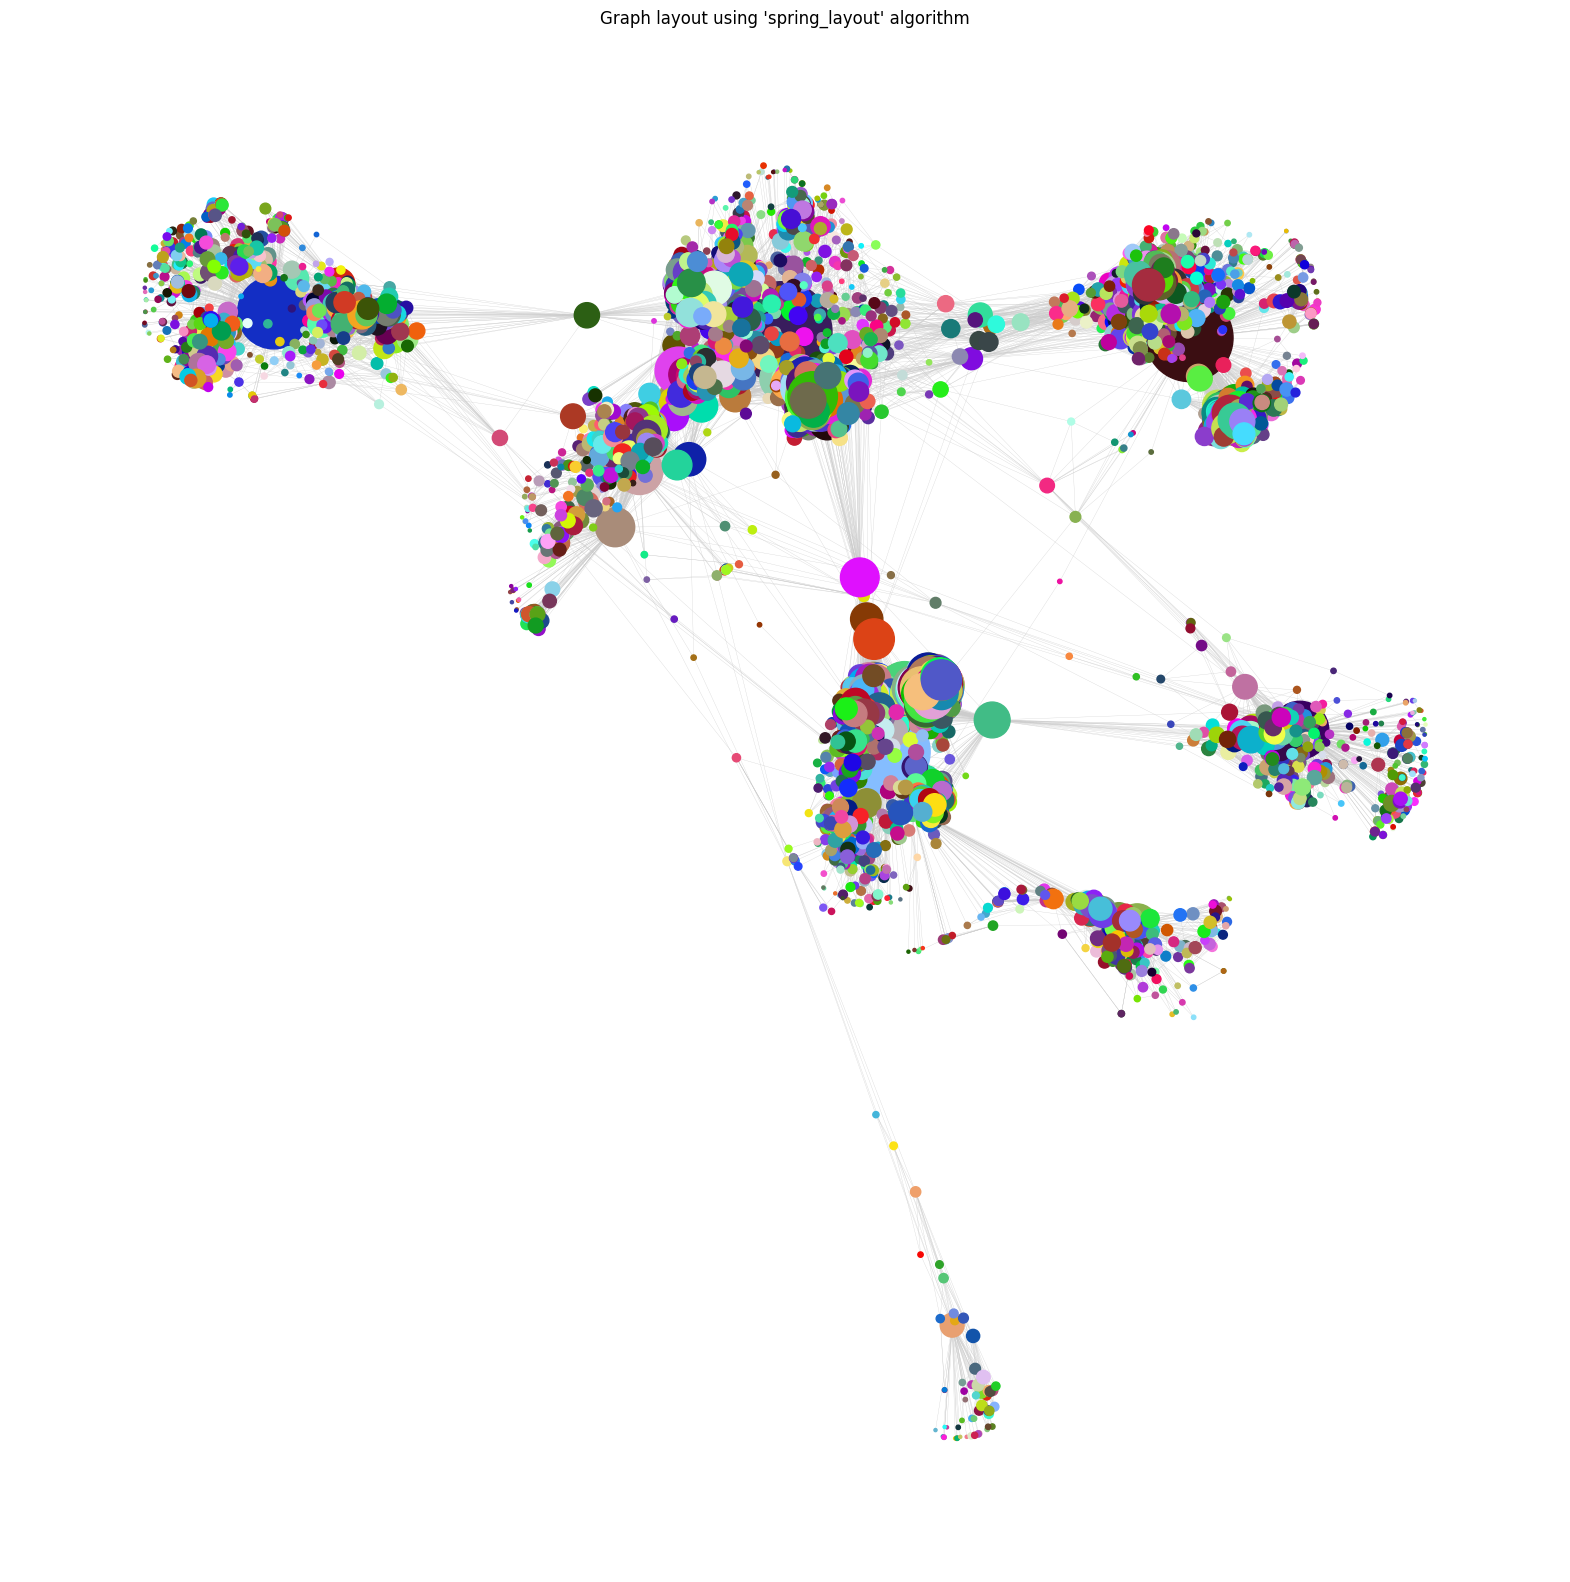

In [4]:
def generate_colors(G):
    random.seed(42)  # Set seed for reproducibility
    return [f"#{random.randint(0, 0xFFFFFF):06x}" for _ in range(len(G.nodes()))]

# Set layout algorithm
layout_algorithm = "spring_layout"

try:
    pos = getattr(nx, layout_algorithm)(G)  # Dynamically call layout functions
except AttributeError:
    raise ValueError(f"Layout algorithm '{layout_algorithm}' is not supported by NetworkX.")

# Plot configuration
plt.figure(figsize=(20, 20))

# Draw nodes
nx.draw_networkx_nodes(
    G, 
    pos, 
    node_size=[5 * G.degree(node) for node in G], 
    node_color=generate_colors(G), 
    cmap=plt.cm.viridis
)

# Draw edges
nx.draw_networkx_edges(G, pos, width=0.2, edge_color="#cccccc")

# Remove axis
plt.axis("off")

# Set title
plt.title(f"Graph layout using '{layout_algorithm}' algorithm")

# Ensure the output directory exists
output_dir = "../images/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save plot
filename = f"{output_dir}graph_{layout_algorithm}.png"
plt.savefig(filename, bbox_inches='tight')

# Show plot
plt.show()

**Features:**
+ <u>Nodes:</u> Represent entities within the network, varying in size and color, possibly indicative of different attributes like degree (number of connections), centrality measures, or other node-specific metrics.
+ <u>Edges:</u> Depict relationships or connections between nodes, with the layout attempting to keep edge lengths uniform to reduce overlap and improve readability.
+ <u>Colors:</u> May denote different clusters or categories within the network, suggesting that a form of community detection or clustering has been applied.
+ <u>Node Size:</u> Could correlate with a node's degree or a centrality measure, where larger nodes have more connections or are more central within the network.

**Interpretation and Analysis:**
+ <u>Clusters:</u> There are visible clusters within the network, suggesting groups of nodes that are more tightly connected to each other than to the rest of the network. This could imply communities or groups with shared properties or interests.
+ <u>Outliers:</u> Some nodes are positioned far from the main clusters, which could indicate outlier entities with fewer connections or differing properties.
+ <u>Network Density:</u> The network appears to have varying densities, with some areas tightly packed and others more sparse, which can be indicative of the network's local and global structure.

**Inferences:**
+ <u>Community Structure:</u> The graph shows distinct clusters, which could correspond to communities within the network. These communities might represent groups with shared characteristics or interactions.
+ <u>Central Nodes:</u> Larger nodes, potentially central or influential within their clusters, may play significant roles within their respective communities.
+ <u>Peripheral Nodes:</u> Nodes at the edges or far from the center may represent peripheral entities with fewer connections or less influence.
+ <u>Inter-Cluster Connectivity:</u> The presence of long edges connecting separate clusters may indicate bridges or gatekeepers between different communities, which are often of interest in social network analysis.
+ <u>Potential Anomalies:</u> Any nodes or subgraphs that show unusual patterns (like isolated nodes or tightly knit small groups disconnected from the main graph) could be anomalies or special cases within the network.

## **Understanding the Graph Features**

Detecting fake profiles in a social network involves identifying unusual patterns of behavior that deviate from typical user activity. The features listed below can provide valuable insights into identifying such anomalies.

**Degree:**

Fake profiles often have an unusually high or low number of connections (degree). A very low degree might suggest limited interaction with others, typical of fake accounts created for specific purposes (e.g., spam). Conversely, a very high degree in a short time frame could indicate automated behavior aimed at mass-connecting with users.

**Triangles:**

The number of triangles a node is part of reflects the level of interconnectedness among a node's neighbors. Fake profiles usually have a lower number of triangles because they are less likely to be embedded in the tightly-knit clusters typical of real users. A fake user might connect randomly rather than forming strong, reciprocated connections, leading to fewer triangles.

**Local Edge Density:**

Local edge density measures how densely connected a node’s immediate neighborhood is. Fake profiles often show lower edge density, as their connections are likely to be less reciprocal and less embedded in the network. They may connect to isolated individuals or scattered nodes, rather than being part of a close-knit community.

**Average Neighbor Degree:**

The average degree of a node’s neighbors can indicate the type of connections the node has. Fake profiles may have connections to either low-degree nodes (other fake profiles or new users) or an abnormally high number of high-degree nodes (targeting influential users). This deviation from the norm can signal the presence of a fake profile.

**Average Path Length:**

Fake profiles may have an unusual average path length. If the profile is isolated or connected to few, far-reaching nodes, the average path length will be longer. Conversely, if the profile is attempting to integrate into a cluster, it might artificially shorten its average path length by connecting to many random users, again showing an anomaly.

**Eigenvector Centrality:**

Eigenvector centrality considers not just the number of connections but the quality of those connections. A fake profile might have a low eigenvector centrality if it connects primarily to low-quality or other fake nodes. Alternatively, a fake profile attempting to imitate a high-profile user might connect to many influential nodes, potentially resulting in anomalously high eigenvector centrality.

**Clustering Coefficient:**

The clustering coefficient measures how likely a node's neighbors are to be connected. Fake profiles typically have lower clustering coefficients because they connect randomly or to isolated users. Real users, by contrast, tend to be part of tight-knit groups where mutual connections are common, leading to higher clustering coefficients.

**Ego Network Size:**

The size of a node's ego network (number of direct connections) can also reveal suspicious activity. Fake profiles might either have very small ego networks (indicating limited social engagement) or unnaturally large ones (due to aggressive connection behavior). The absence of expected connections within this network can further indicate fakeness.

**Summary:**

By analyzing these features, you can detect fake profiles based on their deviations from normal user behavior. Fake users typically show patterns of either excessive or insufficient connectivity, low integration into social clusters, and anomalies in network structure metrics, all of which can be identified through these features.

The code below efficiently extracts a variety of features from the ego networks of nodes in a graph, using parallel processing to improve performance. The addition of community labels enables a deeper analysis of how nodes are organized within the network.

In [5]:
def get_average_neighbor_degree(G):
    avg_neighbor_degree = nx.average_neighbor_degree(G)
    return avg_neighbor_degree

def calculate_local_edge_density(ego_net):
    if len(ego_net) <= 1:
        return 0
    possible_edges = len(ego_net) * (len(ego_net) - 1) / 2
    return len(ego_net.edges()) / possible_edges

def calculate_average_path_length(G, node):
    lengths = nx.single_source_shortest_path_length(G, node)
    return np.mean(list(lengths.values()))

def extract_ego_features(G, node, avg_neighbor_degree):
    ego = nx.ego_graph(G, node)
    features = {
        'node': node,
        'degree': G.degree(node),
        'triangles': nx.triangles(ego).get(node, 0),
        'local_edge_density': calculate_local_edge_density(ego),
        'average_neighbor_degree': avg_neighbor_degree[node],
        'average_path_length': calculate_average_path_length(G, node),
        'eigenvector_centrality': nx.eigenvector_centrality(ego).get(node, 0),
        'clustering_coefficient': nx.clustering(ego).get(node, 0),
        'ego_network_size': len(ego) - 1
    }
    return features

def process_nodes_in_parallel(G, nodes):
    max_workers = max(32, len(nodes))  # Adjust based on system capabilities
    avg_neighbor_degree = get_average_neighbor_degree(G)  # Precompute average neighbor degree
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        features_list = list(executor.map(lambda node: extract_ego_features(G, node, avg_neighbor_degree), nodes))
    
    return features_list

# Extract features for each node in parallel
nodes_to_analyze = list(G.nodes())
features_list = process_nodes_in_parallel(G, nodes_to_analyze)

# Create DataFrame
features_df = pd.DataFrame(features_list)

# Calculate Outliers in Community Embedding
communities = community_louvain.best_partition(G)
features_df['communities'] = features_df['node'].map(communities)

# Display a sample of the DataFrame
features_df.sample(25)

node  degree  triangles  local_edge_density  average_neighbor_degree  \
3487  3443      22        115            0.541502                47.954545   
3145  2205      14         70            0.800000               123.642857   
2149  2315      73       2087            0.799704               132.589041   
2676  3141      11         38            0.742424                80.090909   
2194  1947     120       4060            0.575758               112.058333   
1356  1871      82       1659            0.511607                75.475610   
1901   756      10         31            0.745455                53.100000   
3166  2230       5          9            0.933333               204.600000   
844   1358      77       1244            0.439893                69.376623   
1404  1973      65       1119            0.551981                66.861538   
1710   567      63        831            0.443452                71.873016   
3915  3907      26        227            0.720798                47.076923   
2429  2865      39        261            0.384615                51.307692   
1454  2279     129       5117            0.625641               121.720930   
3534  3493      19        123            0.747368                58.684211   
2079  3540      34        268            0.507563                53.676471   
1215  1730     226      10205            0.406651               118.097345   
3614  3582       3          3            1.000000               196.000000   
1142  1656      34        130            0.275630                82.029412   
2691  3156      13         57            0.769231                93.307692   
65      65      12         33            0.576923                63.500000   
768   1282      68       1336            0.598465                79.029412   
2768  3246      14         56            0.666667                85.642857   
1959   814      26        204            0.655271                44.500000   
1465  2378      50        805            0.670588                65.680000   

      average_path_length  eigenvector_centrality  clustering_coefficient  \
3487             4.174053                0.289733                0.497835   
3145             3.845011                0.304186                0.769231   
2149             3.581580                0.136447                0.794140   
2676             3.537014                0.352635                0.690909   
2194             3.561525                0.138876                0.568627   
1356             3.135677                0.175264                0.499548   
1901             5.606091                0.354644                0.688889   
3166             3.847239                0.428445                0.900000   
844              2.959891                0.207081                0.425154   
1404             3.747710                0.188201                0.537981   
1710             3.039861                0.203101                0.425499   
3915             4.173063                0.234286                0.698462   
2429             3.530082                0.276509                0.352227   
1454             3.483040                0.123908                0.619792   
3534             4.174796                0.278597                0.719298   
2079             3.596187                0.277431                0.477718   
1215             3.113394                0.126176                0.401377   
3614             4.178757                0.500000                1.000000   
1142             2.923001                0.407830                0.231729   
2691             3.536519                0.309522                0.730769   
65               3.826195                0.388352                0.500000   
768              3.140629                0.171288                0.586479   
2768             3.536271                0.327721                0.615385   
1959             5.601634                0.253087                0.627692   
1465             3.751424                0.190932   

In [6]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4039 entries, 0 to 4038
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   node                     4039 non-null   int64  
 1   degree                   4039 non-null   int64  
 2   triangles                4039 non-null   int64  
 3   local_edge_density       4039 non-null   float64
 4   average_neighbor_degree  4039 non-null   float64
 5   average_path_length      4039 non-null   float64
 6   eigenvector_centrality   4039 non-null   float64
 7   clustering_coefficient   4039 non-null   float64
 8   ego_network_size         4039 non-null   int64  
 9   communities              4039 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 315.7 KB


As mentioned earlier, this DataFrame provides insights into the structural properties of nodes within a social network, consisting of 4039 entries and 10 features.

**Key Insights:**

<u>Degree and Triangles:</u> These columns show each node's connectivity and the number of triangles it forms, reflecting local clustering. A high number of triangles indicates that the node is part of tightly-knit groups.

<u>Local Edge Density & Clustering Coefficient:</u> These metrics measure how densely connected a node’s immediate neighbors are. Nodes with high values are likely embedded in close-knit communities, while lower values might indicate more isolated or peripheral nodes.

<u>Average Neighbor Degree & Path Length:</u> These provide a sense of the node’s environment in the network. A high average neighbor degree suggests connections to other influential nodes, while average path length reflects the node’s centrality in the network.

<u>Eigenvector Centrality:</u> Indicates the node’s influence based on its connections to other influential nodes, essential for identifying key players.

<u>Ego Network Size & Communities:</u> These describe the size of a node’s immediate network and its community membership, helping to understand its role within larger network clusters.

This data is pivotal for detecting patterns indicative of fake profiles, particularly through anomalies in connectivity, clustering, and centrality.

### **Using `Community Detection`, `Link Prediction` and `Isolation Forest` methods to label the data**

**1. Community Detection:**

<u>Purpose:</u> Community detection can help identify groups of closely related nodes (users) within the network. By analyzing these communities, you can infer potential labeling, such as identifying outliers or nodes that don’t fit well within any community.

<u>Method:</u>
+ Apply a community detection algorithm like the Louvain method to identify communities.
+ Nodes that don’t belong clearly to a single community or are poorly integrated (e.g., low clustering coefficient, few connections) can be flagged as suspicious or potentially fake.

<u>Labeling:</u> Assign labels based on the degree of integration within communities. For example:
+ Nodes well-integrated into communities might be labeled as real.
+ Nodes that are weakly integrated, bridge different communities unusually, or exist on the periphery might be labeled as potentially fake.

**2. Link Prediction:**

<u>Purpose:</u> Link prediction can assess the likelihood that a connection between two nodes should exist based on network topology. Profiles with unexpected connections (either too many unlikely connections or too few expected ones) might be flagged as suspicious.

<u>Method:</u>
+ Use link prediction algorithms like Common Neighbors, Adamic/Adar, or the Jaccard coefficient to calculate the likelihood of potential connections.
+ Compare the predicted likelihood of connections with the actual connections. Nodes with many unexpected or low-probability connections can be flagged.

<u>Labeling:</u> Assign labels based on the link prediction scores:
+ Nodes with highly probable connections might be labeled as real.
+ Nodes with many low-probability or unexpected connections might be labeled as potentially fake.

**3. Isolation Forest:**

<u>Purpose:</u>
The Isolation Forest algorithm is a powerful tool for identifying outliers in a dataset. In the context of detecting fake profiles in a social network, Isolation Forest can help flag profiles that exhibit anomalous behavior or characteristics compared to the majority of users. These anomalies could indicate potentially fake profiles that are structurally different from genuine users.

<u>Method:</u>

+ Feature Extraction:
First, extract relevant features from the network for each node (user), such as degree, clustering coefficient, average neighbor degree, eigenvector centrality, etc. These features provide a numerical representation of the node's behavior and position in the network.

+ Preprocessing:
To enhance the effectiveness of the Isolation Forest, apply transformations like log transformation (to handle skewed data) and standard scaling (to normalize feature values). This ensures that the algorithm treats all features equally and can detect outliers more accurately.

+ Apply Isolation Forest:
The Isolation Forest algorithm works by randomly selecting a feature and then randomly selecting a split value between the minimum and maximum values of the selected feature. It then isolates observations by recursively splitting the data. Profiles that require fewer splits to be isolated are considered outliers. These outliers are flagged as suspicious, potentially fake profiles.

<u>Labeling:</u>

+ Profiles identified as outliers by the Isolation Forest (those requiring fewer splits for isolation) are labeled as potentially fake.
+ Profiles not identified as outliers are labeled as real.

**Combined Approach:**

<u>Step 1: Community Detection:</u>
+ Detect communities and identify outliers or weakly integrated nodes within these communities.
+ Initial labeling based on community membership and integration (real vs. potentially fake).

<u>Step 2: Link Prediction:</u>
+ Perform link prediction to assess the likelihood of the current connections.
+ Adjust labels based on the congruence between predicted and actual connections.

<u>Step 3: Isolation Forest:</u>
+ Extract features like degree, clustering coefficient, average neighbor degree, eigenvector centrality, etc., for each node.
+ Apply log transformation and standard scaling to normalize the features, ensuring that the Isolation Forest algorithm treats all features equally.
+ Use the Isolation Forest algorithm to detect outliers. The algorithm isolates observations by recursively splitting the data, identifying profiles that deviate significantly from the norm.
+ Profiles that are identified as outliers (requiring fewer splits) are flagged as suspicious.

**Combined Approach Limitations:**

<u>Cumulative Errors:</u>

Errors in one step can propagate and affect subsequent steps. For example, incorrect labeling in the community detection step can influence link prediction, and ultimately, the results of the Isolation Forest.

<u>Lack of Ground Truth:</u>

Since the dataset is initially unlabeled, there is no ground truth to validate the accuracy of the labels generated through this approach. This limits the ability to evaluate the effectiveness of the method objectively.

<u>Bias in Labeling:</u>

Each method has its biases, and these biases can accumulate. For example, community detection might favor densely connected nodes, while Isolation Forest might focus on statistical outliers. The combination of these biases can lead to incorrect or inconsistent labeling.

<u>Complexity in Implementation:</u>

Combining three different methods adds to the complexity of the labeling process. Each method requires careful tuning and validation, making the approach resource-intensive in terms of both computational power and expertise.

**Summary:**

While the 3-step approach offers a comprehensive framework for detecting fake profiles, it is not without limitations. These include dependency on algorithm choices, sensitivity to feature quality, potential biases, computational complexity, and the lack of ground truth for validation. Understanding these limitations is crucial for interpreting the results and for potential improvements or adjustments to the approach.

In [7]:
# Step 1: Community Detection
# Detect communities using the Louvain method
partition = community_louvain.best_partition(G)

# Add community labels to the nodes
nx.set_node_attributes(G, partition, 'community')

# Identify nodes that are weakly integrated within their communities
def weakly_integrated_nodes(G, partition):
    weak_nodes = []
    for node, community in partition.items():
        neighbors = list(G.neighbors(node))
        community_neighbors = [n for n in neighbors if partition[n] == community]
        if len(community_neighbors) < len(neighbors) * 0.5:  # Threshold for weak integration
            weak_nodes.append(node)
    return weak_nodes

weak_nodes = weakly_integrated_nodes(G, partition)

# Initialize labels: 1 for real, 0 for potential fake
labels = {node: 1 for node in G.nodes()}
for node in weak_nodes:
    labels[node] = 0  # Label as potential fake if weakly integrated

# Step 2: Link Prediction
# Perform link prediction using Jaccard coefficient
def link_prediction(G):
    predicted_edges = []
    for u, v in combinations(G.nodes(), 2):
        if not G.has_edge(u, v):
            jaccard_coeff = nx.jaccard_coefficient(G, [(u, v)])
            score = list(jaccard_coeff)[0][2]
            if score > 0.1:  # Threshold for considering an edge likely
                predicted_edges.append((u, v, score))
    return predicted_edges

predicted_edges = link_prediction(G)

# Adjust labels based on link prediction
def adjust_labels_by_link_prediction(G, predicted_edges, labels):
    for u, v, score in predicted_edges:
        if labels[u] == 0 or labels[v] == 0:
            # If both nodes are labeled as potentially fake, keep the label
            continue
        # Adjust labels based on the likelihood of connections
        if labels[u] == 1 and labels[v] == 1:
            labels[u] = 1 if score > 0.1 else 0
            labels[v] = 1 if score > 0.1 else 0

adjust_labels_by_link_prediction(G, predicted_edges, labels)

# Step 3: Isolation Forest
# Define the ColumnTransformer to apply log transformation and scaling to all features except "node"
feature_columns = features_df.columns.difference(['node'])
preprocessor = ColumnTransformer(
    transformers=[
        ('log', FunctionTransformer(np.log1p), feature_columns),
        ('scale', StandardScaler(), feature_columns)
    ],
    remainder='passthrough'
)

# Define the pipeline with the preprocessor and Isolation Forest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('iso_forest', IsolationForest(contamination=0.1, random_state=42))
])

# Apply the pipeline to the features
iso_forest_labels = pipeline.fit_predict(features_df.drop(columns=['node']))

# Update labels based on Isolation Forest
for i, node in enumerate(features_df['node']):
    if iso_forest_labels[i] == -1:  # -1 in Isolation Forest means the point is an outlier
        labels[node] = 0  # Mark as potential fake

# Convert the labels dictionary to a DataFrame
labels_df = pd.DataFrame(list(labels.items()), columns=['node', 'is_real'])

# Merge the labels with the original features DataFrame
features_df['is_real'] = features_df['node'].map(labels)

# Output the labeled dataset
features_df.sample(25)

node  degree  triangles  local_edge_density  average_neighbor_degree  \
2920  3421      20         88            0.514286                94.150000   
1713   570      35        298            0.528571                56.457143   
3422  2577      20        101            0.576190                66.100000   
388    902      46        852            0.830712                94.173913   
156    156      12         35            0.602564                68.833333   
597   1111       9         35            0.977778               126.333333   
540   1054      54        862            0.616835               131.740741   
3844  3831      25        138            0.501538                60.960000   
4032  4032       2          1            1.000000                33.000000   
1933   788       4          4            0.800000                53.250000   
1238  1753      82       2141            0.653247               147.012195   
618   1132     142       5578            0.563380               134.323944   
3645  3616      12         39            0.653846                54.583333   
2759  3236      21        126            0.636364                74.238095   
1719   604      35        370            0.642857                76.942857   
1253  1768     209       8914            0.415721               119.392344   
3803  3788      12         59            0.910256                94.916667   
1085  1599      11         28            0.590909               122.363636   
2711  3183       1          0            1.000000               792.000000   
2085  3741      18        106            0.725146                78.500000   
3553  3514      41        476            0.600465                55.097561   
1503  2649     122       4707            0.643609               119.967213   
1318  1833     191       9086            0.505945               130.183246   
1620   465      78       1280            0.440766                61.038462   
3793  3777      10         27            0.672727                81.200000   

      average_path_length  eigenvector_centrality  clustering_coefficient  \
2920             3.534786                0.304308                0.463158   
1713             3.473632                0.258902                0.500840   
3422             3.843526                0.323781                0.531579   
388              3.163159                0.169970                0.823188   
156              3.640505                0.382616                0.530303   
597              3.172320                0.321957                0.972222   
540              3.155979                0.186774                0.602376   
3844             4.173310                0.302609                0.460000   
4032             5.433771                0.577350                1.000000   
1933             5.607824                0.510036                0.666667   
1238             3.154246                0.149031                0.644685   
618              3.139391                0.129139                0.557187   
3645             4.176529                0.362797                0.590909   
2759             3.534538                0.260574                0.600000   
1719             3.238178                0.221124                0.621849   
1253             3.117603                0.129800                0.410103   
3803             4.176529                0.292404                0.893939   
1085             3.171825                0.382736                0.509091   
2711             3.539490                0.707107                0.000000   
2085             3.600149                0.282557                0.692810   
3553             4.169349                0.217913                0.580488   
1503             3.474622                0.125731                0.637718   
1318             3.127259                0.120556                0.500744   
1620             3.214657                0.200325                0.426240   
3793             4.177024                0.404020   

In [8]:
# Drop the node column
features_df.drop(columns=['node'], inplace=True)

The "node" column typically contains unique identifiers for each node in the network. While these identifiers are useful for referencing specific nodes, they do not provide any meaningful information for analysis or machine learning algorithms. By dropping the "node" column, you ensure that only relevant feature variables (e.g., degree, triangles, clustering coefficient) are included in subsequent analyses.

### **Understand the data distribution in each feature**

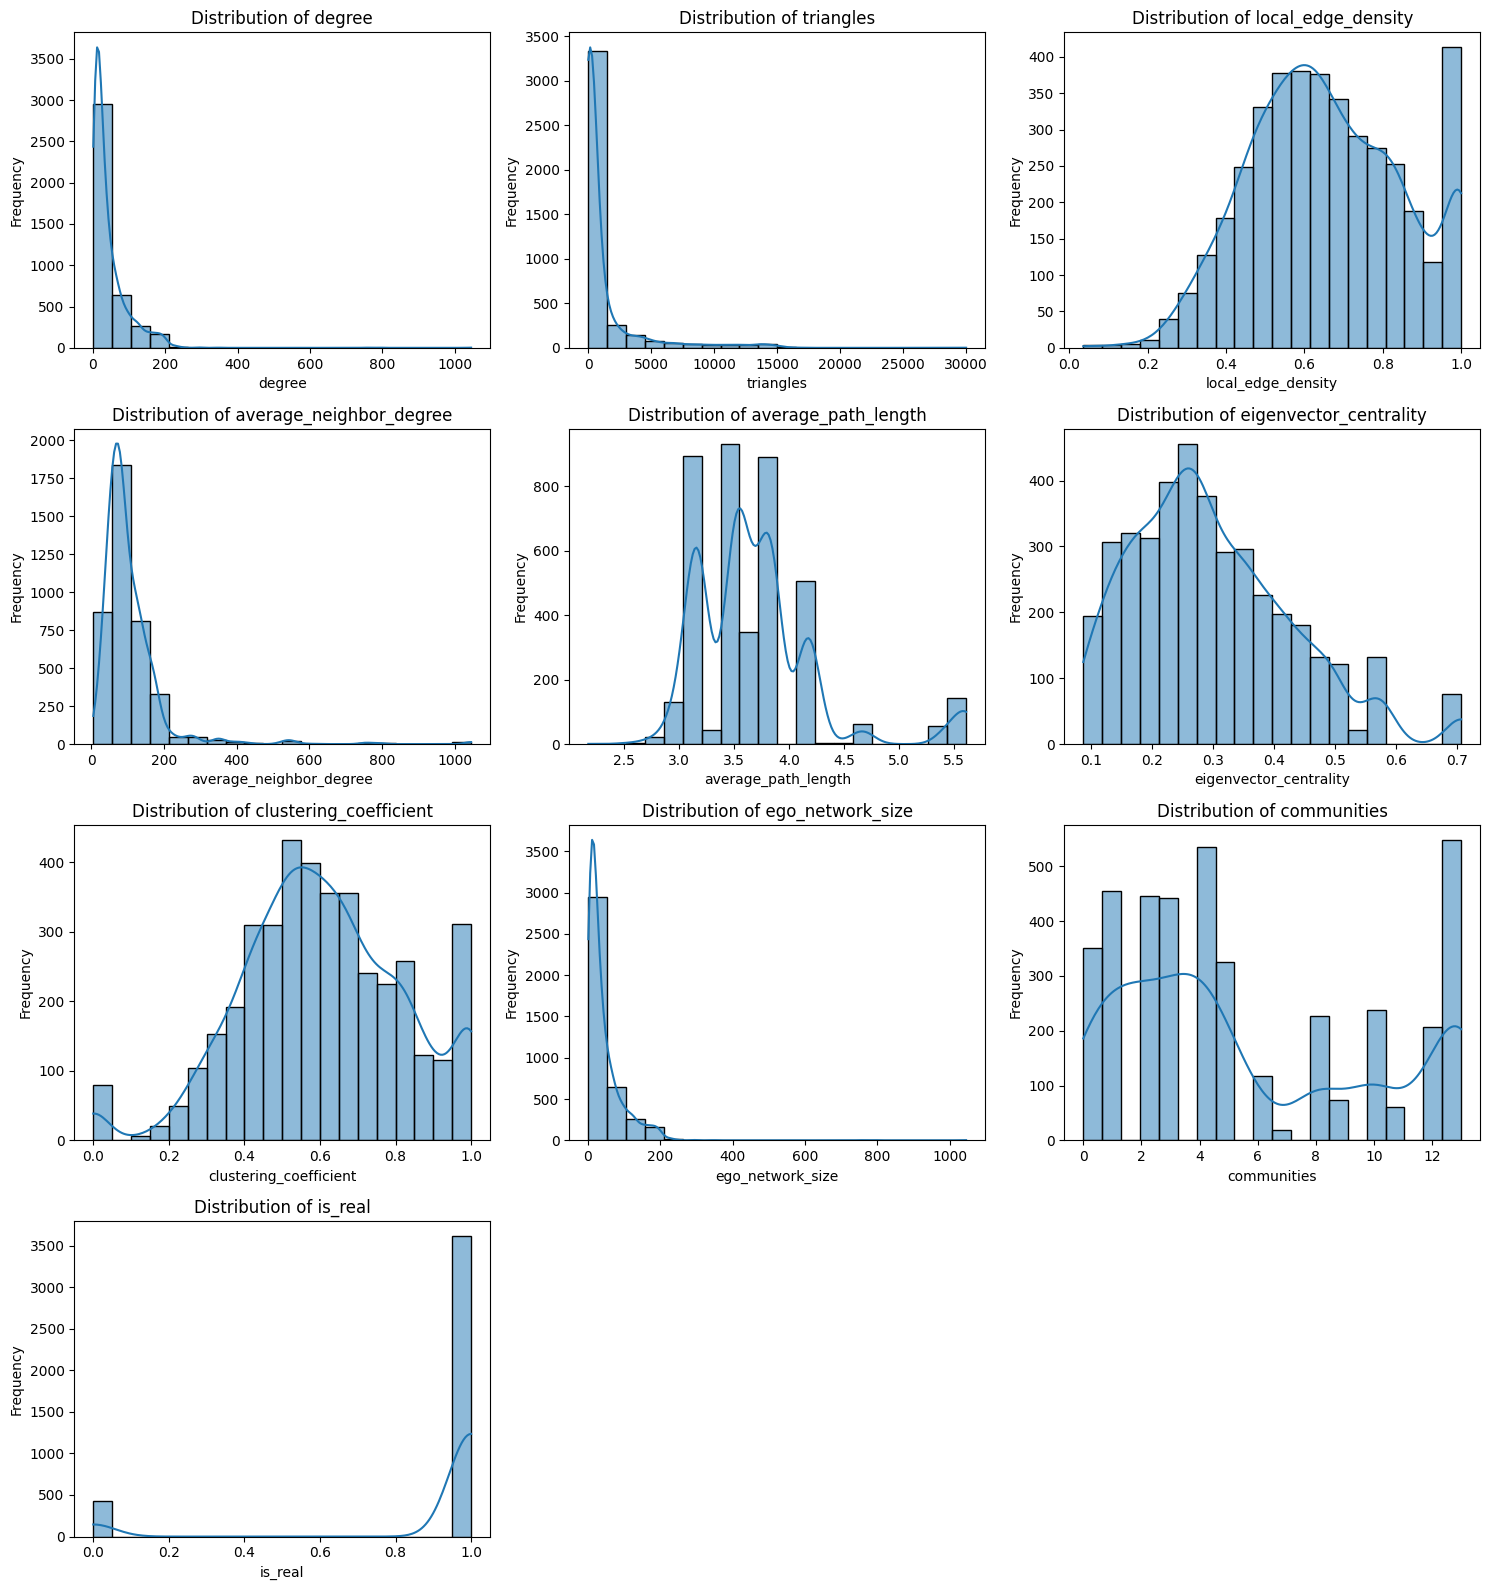

In [9]:
def plot_feature_distributions(df, save_path, bins=20, kde=True):
    """
    Plots the distributions of each feature in the DataFrame.

    Parameters:
        df (DataFrame): The DataFrame with features to plot.
        save_path (str): The file path where the plot image will be saved.
        bins (int): Number of bins to use in the histogram.
        kde (bool): Whether to include a Kernel Density Estimate plot.
    """
    num_features = len(df.columns)
    num_rows = (num_features + 2) // 3

    plt.figure(figsize=(15, 4 * num_rows))
    for i, col in enumerate(df.columns):
        plt.subplot(num_rows, 3, i + 1)
        sns.histplot(data=df, x=col, kde=kde, bins=bins)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")

    plt.tight_layout()
    
    # Ensure the directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

plot_feature_distributions(features_df, "../images/feature-data-distribution.png")

The distributions in the graph provide valuable insights into the structural properties of nodes within the social network:

<u>Degree:</u> The degree distribution is heavily right-skewed, with most nodes having a low degree and a few nodes having extremely high degrees. This indicates a typical power-law distribution often seen in social networks, where a small number of nodes act as hubs with many connections.

<u>Triangles:</u> The triangle distribution is also highly skewed, with many nodes involved in few or no triangles and a few nodes involved in a large number of triangles. This suggests that most nodes are not part of tightly-knit clusters, but some are central in well-connected communities.

<u>Local Edge Density:</u> Local edge density peaks around 0.6 to 0.8, indicating that many nodes have neighbors that are fairly well interconnected. This suggests that nodes tend to cluster in small groups within the network.

<u>Average Neighbor Degree:</u> The distribution is right-skewed, with most nodes connected to neighbors of low degree. This suggests that many nodes are connected to less influential nodes, while a few connect to more influential neighbors.

<u>Average Path Length:</u> The average path length distribution is relatively uniform, with most nodes having an average path length between 3.5 and 5. This suggests that most nodes are reasonably close to others in terms of network distance, reflecting a small-world phenomenon.

<u>Eigenvector Centrality:</u> The distribution is skewed towards lower values, indicating that most nodes have low influence in the network, with a few nodes having significantly higher influence.

<u>Clustering Coefficient:</u> The clustering coefficient shows a peak around 0.3 to 0.6, suggesting moderate clustering among nodes. Nodes are often part of local groups but not in highly clustered cliques.

<u>Ego Network Size:</u> The ego network size distribution is skewed, with most nodes having small ego networks. This indicates that the majority of nodes interact within small local groups rather than having expansive social circles.

<u>Communities:</u> The number of communities a node belongs to is low for most nodes, suggesting that nodes typically belong to a single or a few communities, reinforcing the presence of distinct clusters within the network.

**Summary:**

These distributions reveal a network where a few highly connected nodes play central roles, while most nodes are part of smaller, moderately interconnected clusters. The presence of distinct communities and the skewed distributions in degree, triangles, and centrality highlight the network’s hierarchical and clustered nature, which is typical in social networks and critical in identifying outliers like potential fake profiles.

### **Review the correlation between different features**

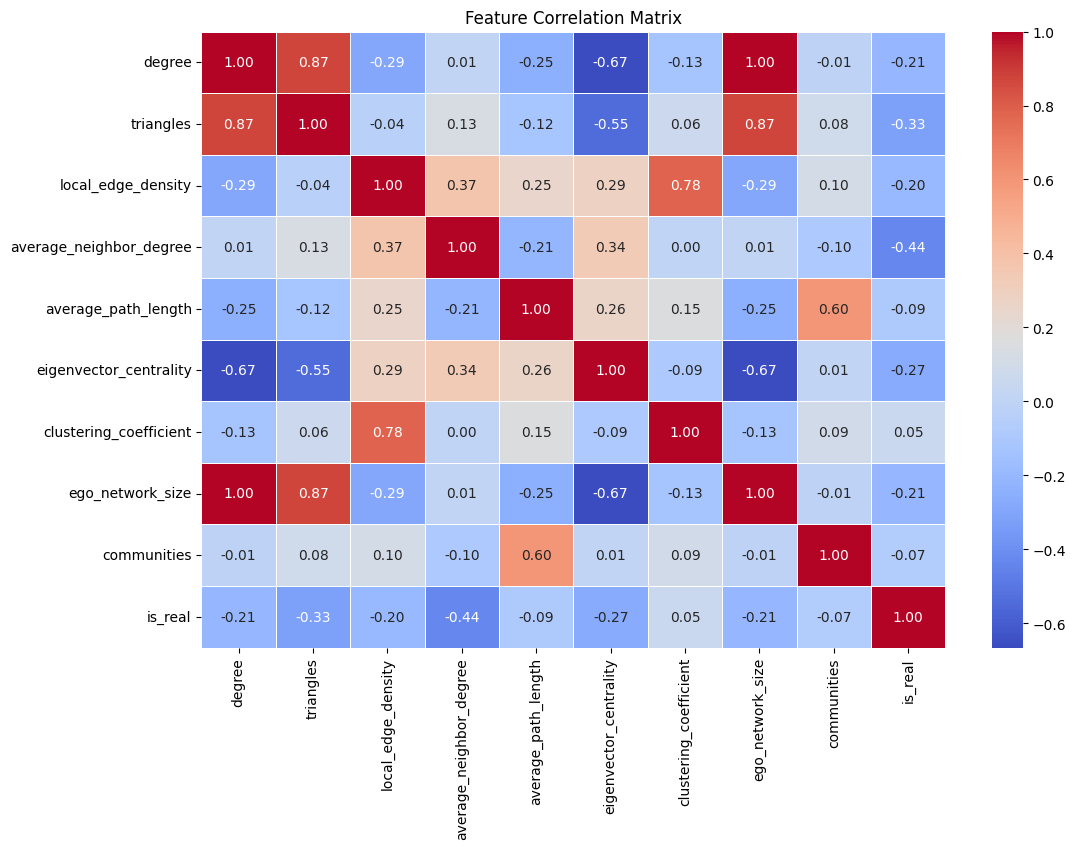

In [10]:
def plot_correlation_matrix(df, save_path, corr_method='pearson', figsize=(12, 8), cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5):
    """
    Plots the correlation matrix heatmap for the given DataFrame and saves the plot to a file.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data to plot.
    save_path (str): The file path where the plot image will be saved.
    corr_method (str): The method of correlation ('pearson', 'spearman', 'kendall').
    figsize (tuple): The size of the figure.
    cmap (str): The color map for the heatmap.
    annot (bool): Whether to annotate the heatmap with correlation coefficients.
    fmt (str): The string formatting code to use when adding annotations.
    linewidths (float): The width of the lines that will divide each cell.

    Returns:
    None
    """
    # Ensure the DataFrame has only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    plt.figure(figsize=figsize)
    sns.heatmap(df.corr(method=corr_method), annot=annot, cmap=cmap, fmt=fmt, linewidths=linewidths)
    plt.title('Feature Correlation Matrix')
    
    # Ensure the directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# Plot the correlation matrix and save the plot
plot_correlation_matrix(features_df, "../images/feature-correlation-matrix.png", corr_method='pearson')

The feature correlation matrix provides insights into the relationships between various network features:

**Key Insights:**

<u>Degree & Ego Network Size:</u>
The perfect correlation (r=1.00) between degree and ego network size is expected, as ego network size is directly derived from the degree of the node.

<u>Degree & Triangles:</u>
A strong positive correlation (r=0.87) between degree and triangles indicates that nodes with more connections are also likely to be part of more triangles, reflecting higher clustering around them.

<u>Local Edge Density & Clustering Coefficient:</u>
These features are highly correlated (r=0.78), suggesting that nodes with a high local edge density are also likely to have a high clustering coefficient, indicating tightly-knit local neighborhoods.

<u>Eigenvector Centrality:</u>
It has a moderately negative correlation with degree (r=−0.67), suggesting that nodes with a higher degree do not necessarily have higher influence in the network, possibly due to connections with less central nodes.

<u>Average Path Length:</u>
This feature has weak correlations with most others, implying that a node's centrality and connections do not strongly predict its average distance to other nodes in the network.

<u>Communities:</u>
The relatively low correlations of community membership with other features suggest that community structure is somewhat independent of individual node characteristics like degree or centrality.

**Summary:**

This matrix reveals the interdependencies between network features, with strong correlations highlighting expected relationships (e.g., degree and ego network size), while weaker correlations suggest more nuanced, independent influences of certain features, such as community membership.

## **Business Objective**

The primary business objective is to enhance the integrity and trustworthiness of the online social network by accurately detecting and mitigating the presence of fake profiles. Fake profiles can be detrimental to the platform's user experience, leading to issues such as spam, fraudulent activities, misinformation spread, and decreased user engagement. By implementing an advanced detection system, the platform aims to:

**Improve User Trust:** Ensure that interactions on the platform are authentic, thereby enhancing user trust and satisfaction.

**Enhance Security:** Protect legitimate users from potential scams, phishing attempts, and other malicious activities often perpetrated by fake profiles.

**Maintain Data Integrity:** Ensure the accuracy of user data for analytics, targeted marketing, and personalized recommendations by removing deceptive accounts.

**Reduce Operational Costs:** Minimize the resources spent on manual moderation and customer support by automating the detection process.

**Compliance and Reputation Management:** Meet regulatory requirements for user authenticity and protect the platform’s reputation from being associated with fraudulent activities.

Overall, detecting fake profiles is crucial for sustaining a healthy, vibrant, and trustworthy online community, leading to long-term user retention and business growth.

## **Feature Engineering**

### **Drop highly correlated features**

The following code performs the necessary steps to reduce multicollinearity by removing redundant features. It uses standard practices such as considering only the upper triangle of the correlation matrix to avoid double-counting correlations.

In [11]:
# Calculate the correlation matrix
correlation_matrix = features_df.corr().abs()

# Select upper triangle of correlation matrix to avoid double-counting correlations
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Define correlation threshold
correlation_threshold = 0.8

# Find features with correlation greater than the threshold
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]

# Drop highly correlated features
features_df = features_df.drop(columns=highly_correlated_features)

# Output dropped and remaining features
print("Features dropped due to high correlation:", highly_correlated_features)
print("Remaining features:", features_df.columns)

Features dropped due to high correlation: ['triangles', 'ego_network_size']
Remaining features: Index(['degree', 'local_edge_density', 'average_neighbor_degree',
       'average_path_length', 'eigenvector_centrality',
       'clustering_coefficient', 'communities', 'is_real'],
      dtype='object')


Dropping highly correlated features like `triangles` and `ego_network_size` is crucial to avoid multicollinearity, which can distort model coefficients and lead to overfitting. "Triangles" is highly correlated with "degree," as nodes with higher degrees typically form more triangles. "Ego network size" is directly derived from "degree," offering redundant information. Removing these features simplifies the model, reduces redundancy, and improves interpretability without sacrificing predictive power, ensuring that each feature contributes unique information to the analysis.

### **Review feature correlation after normalization**

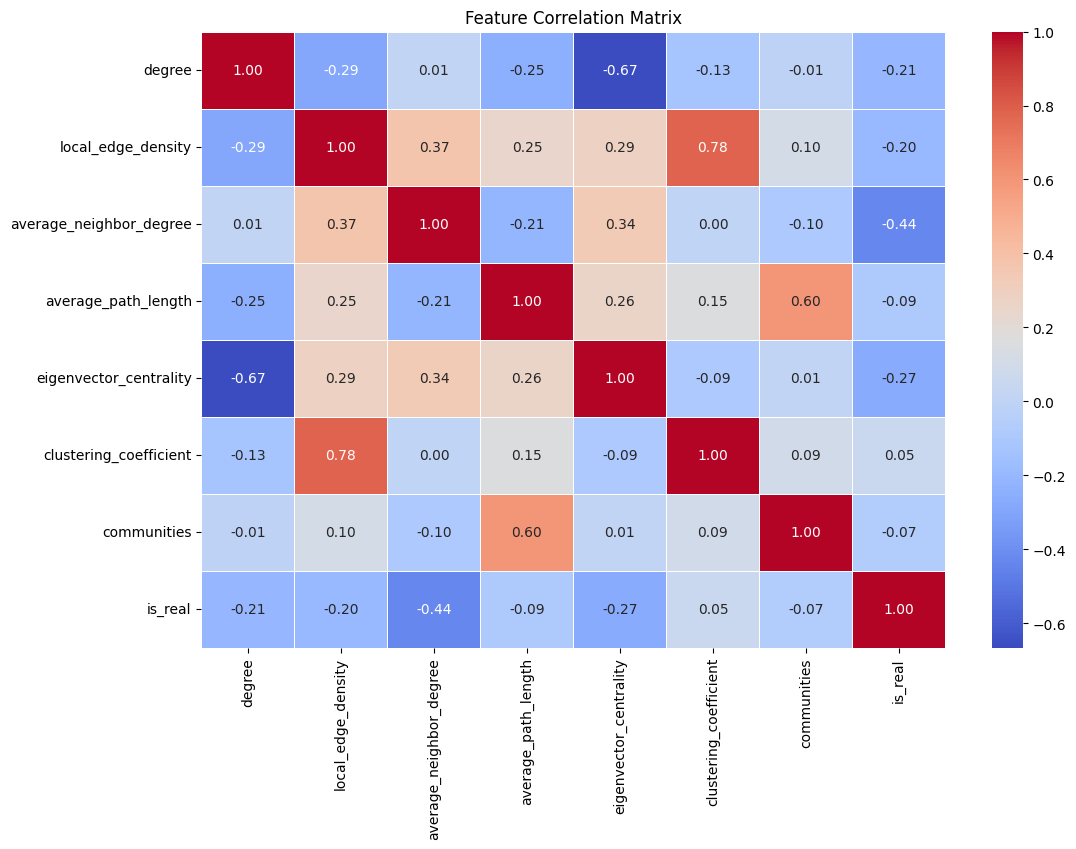

In [12]:
# Plot the correlation matrix and save the plot
plot_correlation_matrix(features_df, "../images/feature-correlation-matrix-after-normalization.png")

This correlation matrix reveals key relationships among features after normalization. `Degree` and `eigenvector_centrality` show a strong negative correlation (-0.67), indicating that nodes with many connections might not always be the most influential.   `Clustering_coefficient` is highly correlated with `local_edge_density` (0.78), suggesting that nodes in dense local networks also have tightly-knit neighborhoods. The `is_real` label shows moderate negative correlations with `average_neighbor_degree` (-0.42) and `eigenvector_centrality` (-0.29), indicating that potentially fake profiles may have lower neighbor degrees and influence within the network. These insights highlight potential patterns for detecting fake profiles.

### **Apply data transformations to normalize the features: Log Transformer & Standard Scaler**

The following code preprocesses all features in a dataset by applying a safe log transformation (to handle zero or negative values) followed by standard scaling. The `safe_log_transform` function ensures all values are positive before applying `log1p`. A `ColumnTransformer` is used to apply these transformations across all features. The processed data is then ready for analysis and modeling.

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Handle zero or negative values by adding a small constant before applying log transformation
def safe_log_transform(x):
    x = np.where(x <= 0, 1e-6, x)
    return np.log1p(x)

# Exclude 'is_real' from transformations
numeric_columns = features_df.columns.drop('is_real')

# Ensure columns are of type float for the transformation
features_df[numeric_columns] = features_df[numeric_columns].astype(float)

# Define and apply the ColumnTransformer
log_transformer = FunctionTransformer(safe_log_transform, validate=False)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('log', log_transformer), ('scaler', StandardScaler())]), numeric_columns),
    ])

# Preprocess the data
data_preprocessed = preprocessor.fit_transform(features_df[numeric_columns])
data_preprocessed_df = pd.DataFrame(data_preprocessed, columns=numeric_columns)

# Reintegrate 'is_real' correctly
data_preprocessed_df['is_real'] = features_df['is_real'].reset_index(drop=True)
features_df = data_preprocessed_df

# Display a few rows
features_df.sample(25)

degree  local_edge_density  average_neighbor_degree  \
2511 -0.557242           -0.334308                -0.034648   
1464  0.856132           -0.076838                -0.639251   
515   1.031480           -1.119346                 0.479593   
107   3.374682           -3.803080                -0.779468   
1113 -1.699139            1.650222                 2.385989   
3942 -0.777062            0.496652                -0.005148   
899   0.784323           -0.102883                -0.088128   
1001  0.909766           -0.772374                -0.109122   
3638 -0.232132            0.782149                -0.742225   
447  -0.557242           -1.533360                 0.333941   
3237  1.438272            0.918064                 1.206793   
1829 -1.495743            1.215568                -2.386825   
403   1.481006           -2.393864                -0.645802   
265   0.074564            0.105248                -0.879800   
2588 -0.959974           -0.182030                 0.413769   
1585 -0.278886           -0.228293                -0.503546   
3911 -0.278886            0.281794                -0.720290   
2375  0.621120           -0.896821                -0.195628   
1543 -1.961362            1.650222                 0.539650   
1640 -0.028736            0.372165                -1.039821   
1351  0.196278           -0.742129                -0.620067   
2859 -0.624791           -0.432957                 0.254231   
1861 -0.624791            0.039813                -1.326076   
2083  0.376597           -0.595354                -0.743017   
1379  0.828084           -0.495618                -0.166954   

      average_path_length  eigenvector_centrality  clustering_coefficient  \
2511            -0.243991                0.400401               -0.362142   
1464             0.165093               -0.928910                0.130737   
515             -1.461119               -0.888623               -0.778158   
107             -3.452812               -1.268399               -3.005143   
1113            -0.993177                1.515643                1.653282   
3942             0.943373                0.569303                0.432668   
899             -1.023626               -0.926965                0.103263   
1001            -1.072454               -0.787689               -0.481256   
3638             0.939503               -0.274101                0.826679   
447             -1.011862                1.293260               -1.629598   
3237             0.296804               -1.595145                1.018921   
1829             1.402263                1.375104                1.025120   
403             -1.106954               -0.750899               -1.860848   
265              0.305578               -0.418948                0.225117   
2588            -0.241538                1.065940               -0.423583   
1585            -0.344152                0.333588               -0.161034   
3911             0.939933               -0.032438                0.337047   
2375            -0.262164               -0.533563               -0.620730   
1543             0.077937                2.022423                1.653282   
1640             0.031900               -0.331422                0.461521   
1351            -1.419083               -0.189322               -0.543603   
2859            -0.243501                0.668214               -0.496876   
1861             3.134212                0.504940                0.001204   
2083            -0.128450               -0.489787               -0.379220   
1379            -1.062237               -0.937717               -0.242285   

      communities  is_real  
2511     0.004761        1  
1464     0.880436        1  
515     -0.640581        1  
107     -0.640581        0  
1113    -0.640581        1  
3942     1.305512        1  
899      0.235094        1  
1001     0.235094        1  
3638     1.305512        1  
447     -0.640581        1  
3237     1.000845        1  
1829     1.110769 

### **Review data distribution in each feature after normalization**

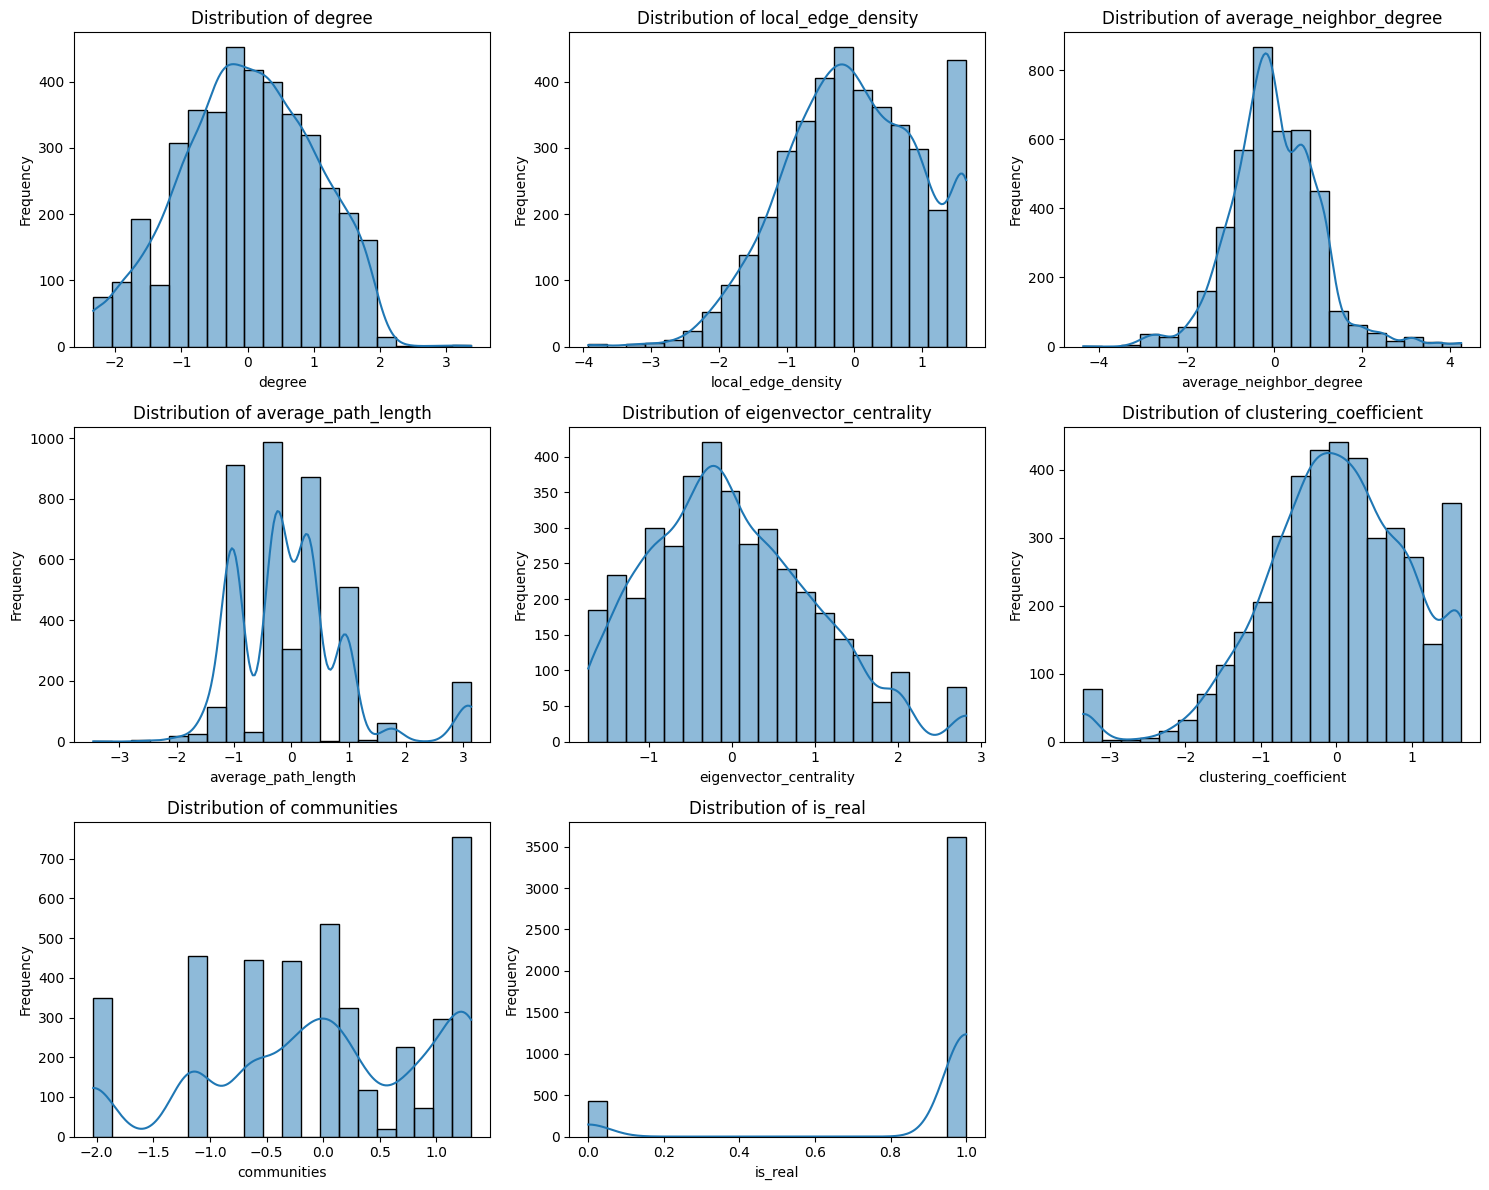

In [14]:
plot_feature_distributions(features_df, "../images/feature-data-distribution-after-normalization.png")

This chart displays the distributions of various network features after normalization, with the `is_real` feature indicating real (1) versus potentially fake (0) profiles. Most features now follow a roughly normal distribution centered around 0, indicating successful normalization. However, `average_path_length` shows multiple peaks, suggesting different behavioral patterns among users. The `is_real` distribution reveals a clear imbalance, with a majority labeled as real, indicating that fake profiles are relatively rare. The skew in some features, like `local_edge_density` and `clustering_coefficient`, suggests differing levels of network integration among users.

### **Visualize label `is_real` distribution using a histogram**

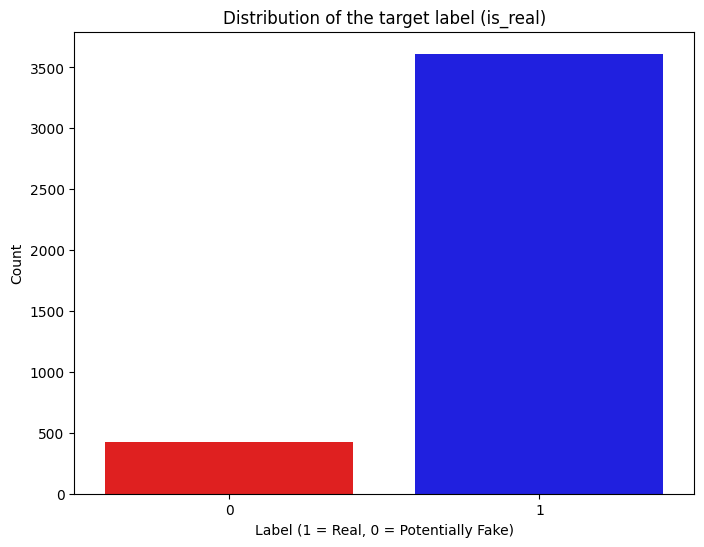

In [15]:
def plot_label_distribution(df, column_name, figsize=(8, 6)):
    """
    Plots the distribution of a specified column in the given DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to plot the distribution for.
    figsize (tuple): The size of the plot.

    Returns:
    None
    """
    # Ensure column has only the expected unique values (0 and 1)
    if not set(df[column_name].unique()).issubset({0, 1}):
        raise ValueError(f"Unexpected values found in {column_name}. Expected only 0 and 1.")
    
    # Calculate the value counts for the specified column
    label_counts = df[column_name].value_counts().reset_index()
    label_counts.columns = [column_name, 'count']

    # Define the custom palette with blue for "Real" and red for "Fake"
    custom_palette = {1: 'blue', 0: 'red'}

    # Plot the distribution of the specified column
    plt.figure(figsize=figsize)
    sns.barplot(data=label_counts, x=column_name, y='count', hue=column_name, palette=custom_palette, dodge=False)
    plt.xlabel('Label (1 = Real, 0 = Potentially Fake)')
    plt.ylabel('Count')
    plt.title(f'Distribution of the target label ({column_name})')
    plt.legend([], [], frameon=False)  # Hide the default legend
    plt.show()

# Plot the distribution of 'is_real'
plot_label_distribution(features_df, 'is_real')

The histogram provides a straightforward view of how many profiles are labeled as real vs. potentially fake. It helps in understanding the overall balance or imbalance in the dataset.

### **Visualize label `is_real` distribution across all features**

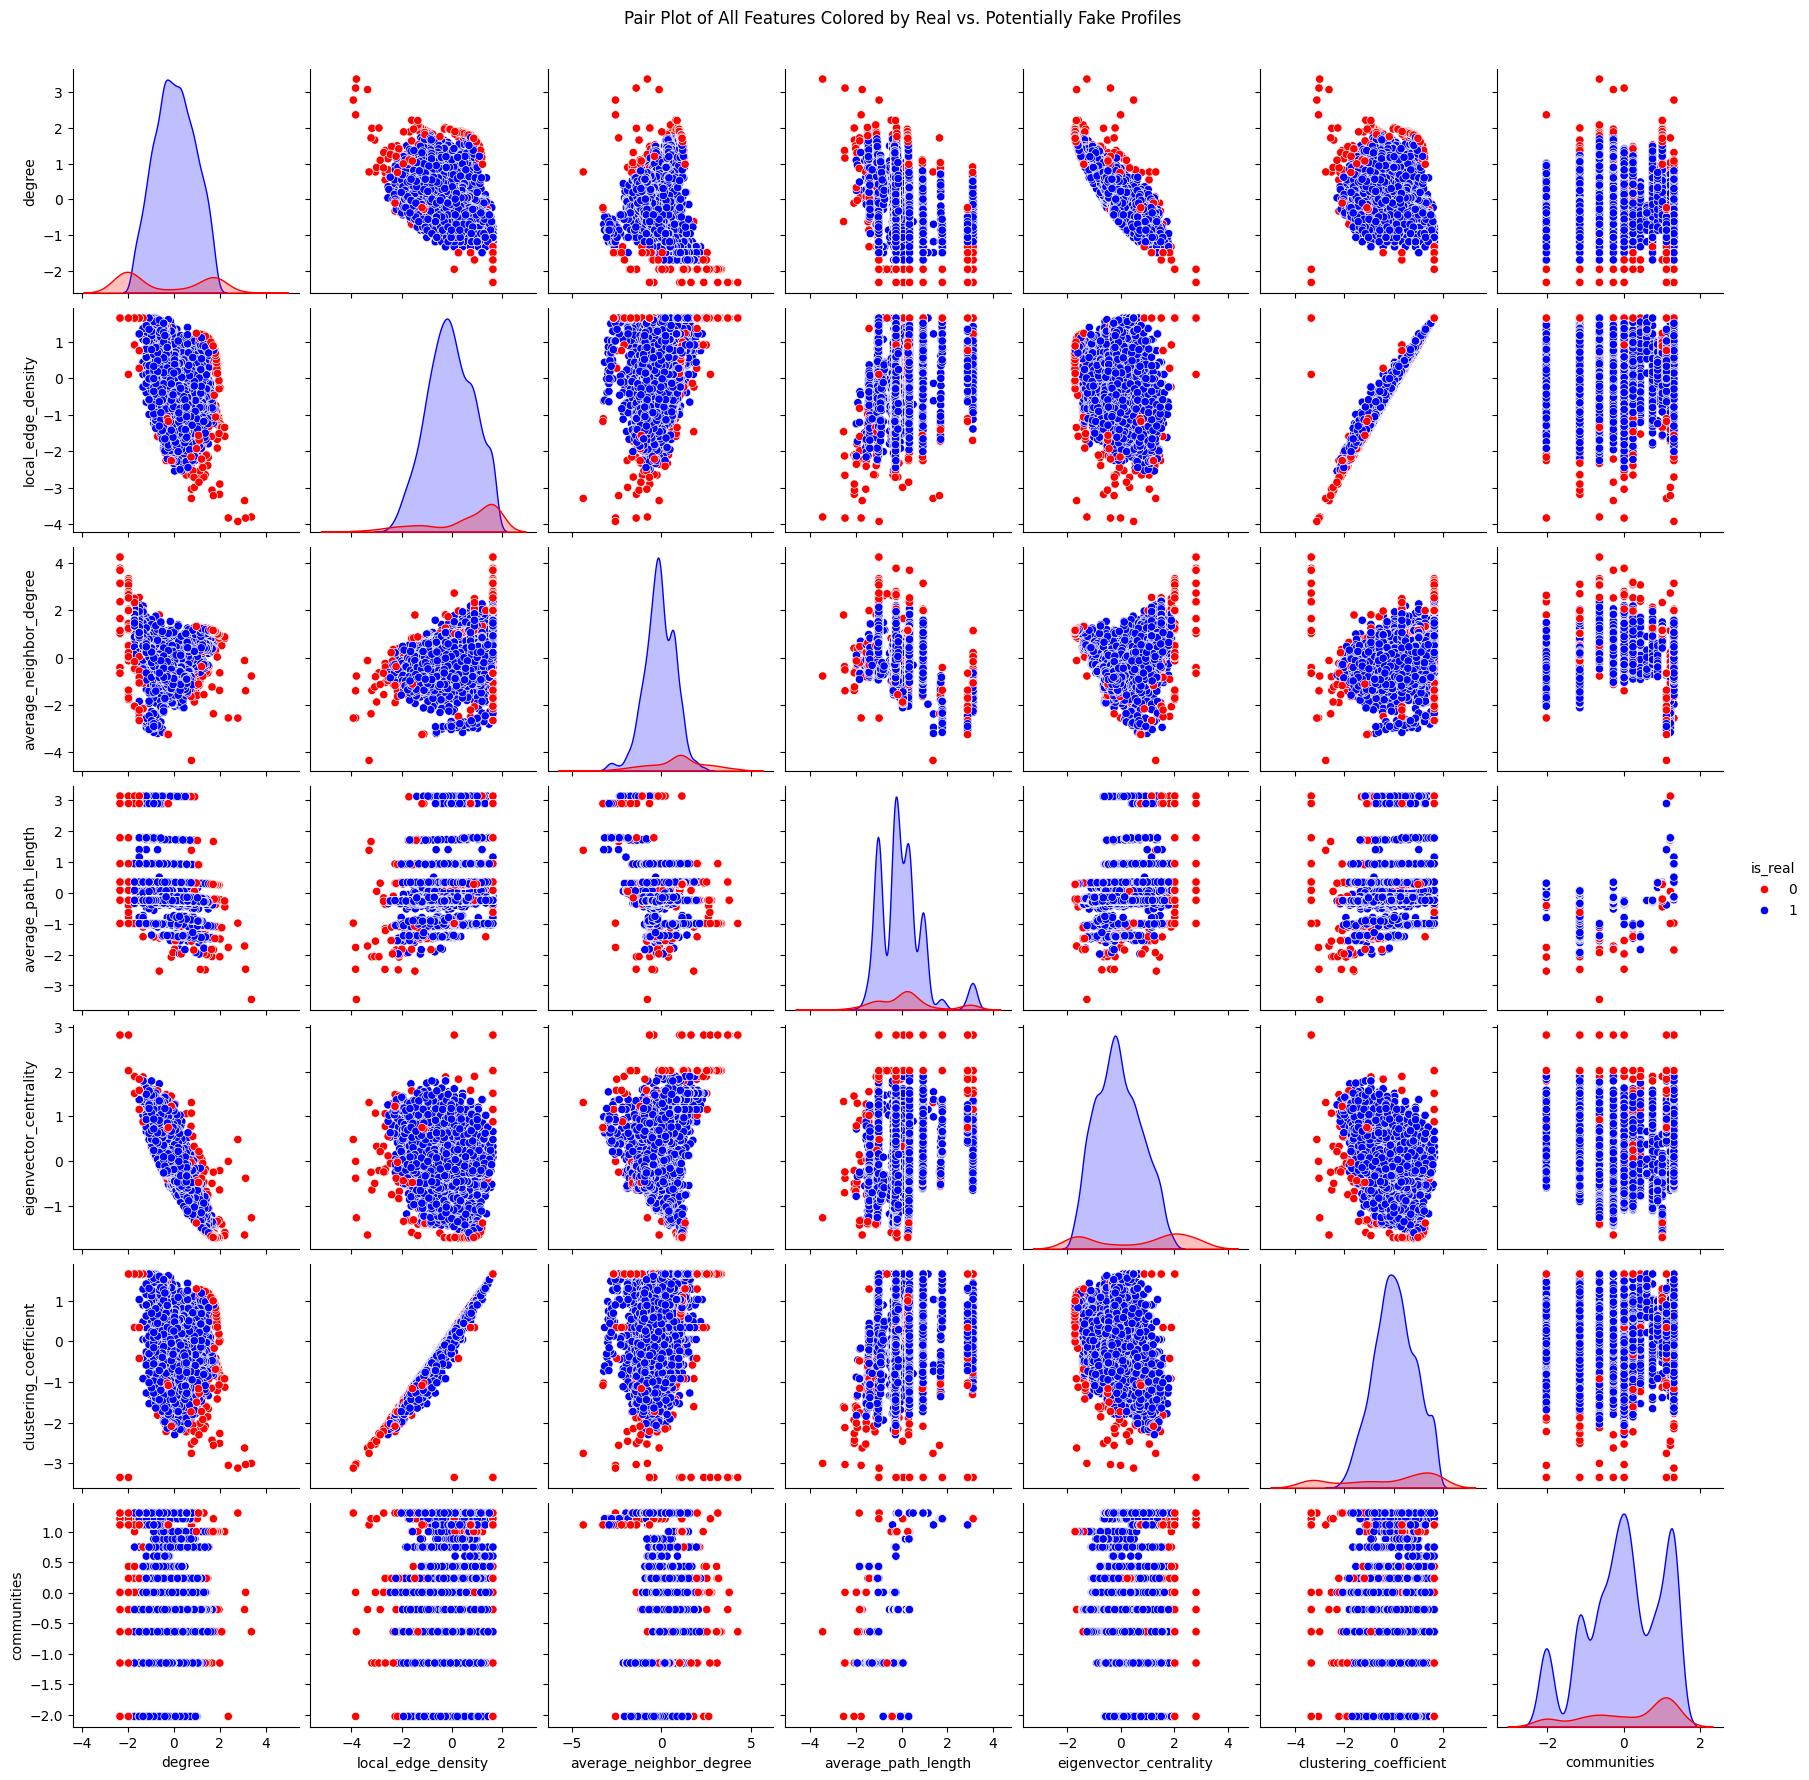

In [16]:
# Create a pair plot with different colors for real vs. potentially fake profiles
sns.pairplot(features_df, hue='is_real', palette={1: 'blue', 0: 'red'}, diag_kind='kde')

# Adjust the size of the plot
plt.suptitle('Pair Plot of All Features Colored by Real vs. Potentially Fake Profiles', y=1.02)
plt.savefig('../images/pair-plot-all-features.png', bbox_inches='tight')
plt.show()

This pair plot provides a detailed visualization of the relationships between various features, with real profiles (in blue) and potentially fake profiles (in red) clearly distinguished.

**Key Insights:**

<u>Feature Clustering:</u> Real profiles are generally clustered tightly across multiple features, indicating consistency in behavior and network integration. Potentially fake profiles, however, are more dispersed, especially in features like `degree`, `eigenvector_centrality`, and `clustering_coefficient`, suggesting irregular or anomalous behavior.

<u>Separation in Certain Features:</u> There is noticeable separation between real and potentially fake profiles in features like `eigenvector_centrality` and `average_neighbor_degree`. Fake profiles tend to have lower centrality and neighbor degrees, implying they are less connected to influential nodes.

<u>Overlap in Some Features:</u> Despite some separation, there is significant overlap in features like `local_edge_density` and `communities`, indicating that these features alone may not be sufficient to distinguish between real and fake profiles.

<u>Bimodal Distributions:</u> The distribution of `average_path_length` shows a bimodal pattern, suggesting distinct subgroups within the profiles. This could be indicative of different types of user behavior among real and fake profiles.

**Summary:**

The pair plot reveals that while certain features can help differentiate between real and potentially fake profiles, the overlap and dispersion in others highlight the complexity of the detection task. Combining multiple features and considering their interactions is crucial for effective identification of fake profiles.

### **Key Features Impacting the `is_real` Label**

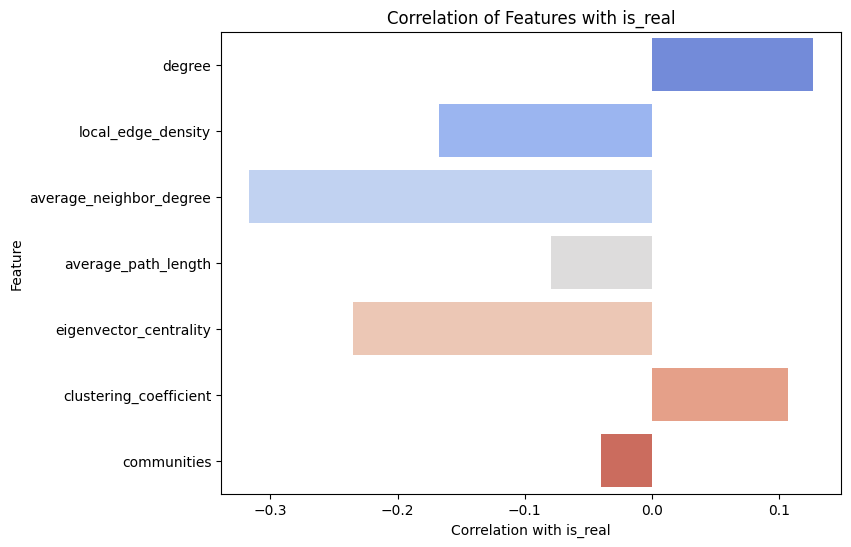

In [17]:
# Calculate correlation matrix and select only correlations with 'is_real'
correlation_with_target = features_df.corr()['is_real'].drop('is_real')

# Convert to DataFrame for easy plotting
correlation_with_target_df = correlation_with_target.to_frame().reset_index()
correlation_with_target_df.columns = ['Feature', 'Correlation with is_real']

# Plot the correlation with the target label
plt.figure(figsize=(8, 6))
sns.barplot(data=correlation_with_target_df, x='Correlation with is_real', y='Feature', hue='Feature', dodge=False, palette='coolwarm', legend=False)
plt.title('Correlation of Features with is_real')
plt.show()

**Average Neighbor Degree:**

<u>Correlation:</u> The `average_neighbor_degree` has a moderate negative correlation (-0.44) with the `is_real` label.
<u>Impact:</u> Profiles with lower average neighbor degrees are more likely to be labeled as fake. This suggests that fake profiles often connect with less influential or less connected nodes.

**Eigenvector Centrality:**

<u>Correlation:</u> `Eigenvector_centrality` also shows a moderate negative correlation (-0.27) with the `is_real` label.
<u>Impact:</u> Lower eigenvector centrality indicates less influence within the network, which is more characteristic of fake profiles.

**Degree:**

<u>Correlation:</u> `Degree` has a small negative correlation (-0.21) with the `is_real` label.
<u>Impact:</u> Fake profiles tend to have a lower degree, meaning they have fewer connections compared to real profiles.

**Local Edge Density:**

<u>Correlation:</u> `Local_edge_density` has a negative correlation (-0.20) with the `is_real` label.
<u>Impact:</u> Lower local edge density is associated with fake profiles, indicating that their connections are less clustered.

**Summary:**
The features that most impact the `is_real` label are `average_neighbor_degree`, `eigenvector_centrality`, `degree`, and `local_edge_density`. These features suggest that fake profiles typically have lower connectivity, influence, and integration within the network. These insights can guide the development of more effective detection models by focusing on these key features.

In [18]:
# List of important features to retain
important_features = ['average_neighbor_degree', 'eigenvector_centrality', 'degree', 'local_edge_density']

# Retain only the important features and the target label (is_real)
features_df = features_df[important_features + ['is_real']]

# Display the few rows of the updated DataFrame
features_df.sample(25)

average_neighbor_degree  eigenvector_centrality    degree  \
3521                -0.756639               -0.206723 -0.435528   
1101                -0.413570               -0.210759 -0.028736   
500                 -0.313557               -0.860602  1.234876   
1839                -1.412266               -0.604225  0.689946   
2831                -0.780564               -0.264777 -0.187659   
2475                -0.119621               -1.091234  1.118355   
373                 -0.344849               -0.557177  1.086739   
3798                -0.666933               -0.144975 -0.557242   
2299                 2.196884                1.515643 -1.699139   
3869                -0.486833                0.040570 -0.697751   
770                 -0.038128               -0.891330  0.784323   
1270                -0.216184                0.352960  0.167339   
553                 -0.154243               -1.032192  0.996641   
1118                 0.889117               -1.102502  1.031480   
1095                 0.703579               -1.080213  1.168728   
687                  0.851590               -0.878405  0.753937   
3189                 0.595972               -0.882939  0.706370   
1357                 0.004624               -0.778897  0.621120   
518                 -0.243511               -0.944003  1.031480   
1030                 0.461251                0.235717 -0.435528   
1784                -1.744483               -0.581729 -0.104738   
990                 -0.539072               -0.476867  0.753937   
195                 -1.048284                0.198380 -0.863937   
713                 -0.228095               -1.021658  1.086739   
3838                -0.873776               -0.532568  0.621120   

      local_edge_density  is_real  
3521            1.362944        1  
1101            0.071285        1  
500            -1.211114        1  
1839           -0.885133        1  
2831            0.530212        1  
2475           -0.344799        1  
373            -1.491725        1  
3798            1.556587        1  
2299            1.650222        1  
3869            1.520847        1  
770            -0.298753        1  
1270           -1.463814        1  
553            -0.292599        1  
1118           -0.115895        1  
1095           -0.447192        1  
687             0.061553        1  
3189           -0.299340        1  
1357           -0.186844        1  
518            -0.734102        1  
1030           -0.065947        1  
1784            1.220855        1  
990            -1.057612        1  
195             1.650222        1  
713            -0.609062        1  
3838           -0.719165        1

### **Apply `SMOTE` to fix class imbalance on the training data**

The following code handles class imbalance in the dataset by applying SMOTE (Synthetic Minority Over-sampling Technique). It first separates the features (`X`) and the target label (`y`), then splits the data into training and testing sets. The class distribution in the training set is displayed before applying SMOTE, highlighting any imbalance. SMOTE is then applied to generate synthetic samples for the minority class, ensuring a balanced training set. Finally, the class distribution after SMOTE is displayed, confirming that the dataset is now balanced, which helps improve model performance and fairness.

In [19]:
# Separate the features and the target label
y = features_df['is_real']
X = features_df.drop(['is_real'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display class distribution before applying SMOTE
print("Class Distribution Before SMOTE:")
print(y_train.value_counts().to_frame().rename(columns={y_train.name: 'Count'}))

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Display class distribution after applying SMOTE
print("\nClass Distribution After SMOTE:")
print(pd.Series(y_train).value_counts().to_frame().rename(columns={y_train.name: 'Count'}))

Class Distribution Before SMOTE:
         count
is_real       
1         2528
0          299

Class Distribution After SMOTE:
         count
is_real       
1         2528
0         2528


In [21]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4039 entries, 0 to 4038
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   average_neighbor_degree  4039 non-null   float64
 1   eigenvector_centrality   4039 non-null   float64
 2   degree                   4039 non-null   float64
 3   local_edge_density       4039 non-null   float64
 4   is_real                  4039 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 157.9 KB


## **Modeling using Traditional Machine Learning Algorithms**

This code systematically evaluates four machine learning models (Logistic Regression, k-Nearest Neighbors, Decision Tree, and SVM) using stratified cross-validation. It defines pipelines and hyperparameter grids for each model, then uses `GridSearchCV` to find the best hyperparameters. The models are evaluated on both training and testing sets, capturing metrics like accuracy, precision, recall, and F1-score. Results are stored in two separate DataFrames: one for training metrics and one for testing metrics, allowing for a clear comparison of model performance across different phases.

In [67]:
# Define pipelines for each model
pipelines = {
    'Naive Bayes': Pipeline([
        ('classifier', GaussianNB())
    ]),
    'Logistic Regression': Pipeline([
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'AdaBoost': Pipeline([
        ('classifier', AdaBoostClassifier(algorithm='SAMME', random_state=42))
    ]),
    'SVM': Pipeline([
        ('classifier', SVC(random_state=42))
    ]),
    'k-Nearest Neighbors': Pipeline([
        ('classifier', KNeighborsClassifier())
    ]),
    'Decision Tree': Pipeline([
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))
    ])
}

# Define hyperparameter grids for each model
param_grids = {
    'Naive Bayes': {
        # No hyperparameters to tune for GaussianNB
    },
    'Logistic Regression': {
        'classifier__C': [1, 10, 100, 200],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    },
    'AdaBoost': {
        'classifier__n_estimators': [250, 300, 350],
        'classifier__learning_rate': [0.01, 0.1, 1.0, 2.0]
    },
    'SVM': {
        'classifier__C': [10, 100, 200],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    },
    'k-Nearest Neighbors': {
        'classifier__n_neighbors': [1, 3, 5],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        'classifier__max_depth': [10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 5]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 20, 30, 40, 50],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__bootstrap': [True, False]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.1, 0.2, 0.3],
        'classifier__max_depth': [5, 7, 9],
        'classifier__subsample': [0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.8, 0.9, 1.0]
    }
}

# Use StratifiedKFold for stratified cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV for each model with stratified cross-validation
best_estimators = {}
for model_name, pipeline in pipelines.items():
    if model_name == 'Naive Bayes':  # Naive Bayes has no hyperparameters to tune in this case
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        train_time = time.time() - start_time
        best_estimators[model_name] = {
            'best_estimator': pipeline,
            'best_params': 'N/A',
            'train_time': train_time
        }
    else:
        grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=stratified_kfold, scoring='accuracy', n_jobs=-1)
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        train_time = time.time() - start_time
        best_estimators[model_name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_params': grid_search.best_params_,
            'train_time': train_time
        }

# Evaluate each best model
train_results = []
test_results = []
for model_name, model_info in best_estimators.items():
    best_model = model_info['best_estimator']
    train_time = model_info['train_time']
    best_params = model_info['best_params']

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Training metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)

    # Testing metrics
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)

    # Append training results
    train_results.append({
        'Model': model_name,
        'Train Time (s)': train_time,
        'Train Accuracy': train_acc,
        'Train Precision': train_precision,
        'Train Recall': train_recall,
        'Train F1 Score': train_f1,
        'Best Parameters': best_params
    })

    # Append testing results
    test_results.append({
        'Model': model_name,
        'Test Accuracy': test_acc,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1 Score': test_f1,
        'Best Parameters': best_params
    })

# Create DataFrames to display the results
train_results_df = pd.DataFrame(train_results)
test_results_df = pd.DataFrame(test_results)

/Users/vijay/.pyenv/versions/3.12.3/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### **Train Results**

In [68]:
# Display the training results
train_results_df

Model  Train Time (s)  Train Accuracy  Train Precision  \
0          Naive Bayes        0.002342        0.837737         0.815935   
1  Logistic Regression        1.534917        0.906940         0.903756   
2             AdaBoost        3.094780        0.941049         0.932020   
3                  SVM        1.274500        0.969440         0.966680   
4  k-Nearest Neighbors        0.089554        1.000000         1.000000   
5        Decision Tree        0.126065        1.000000         1.000000   
6        Random Forest       64.447057        1.000000         1.000000   
7              XGBoost        5.517897        0.999409         1.000000   

   Train Recall  Train F1 Score  \
0      0.872240        0.843148   
1      0.910883        0.907306   
2      0.951498        0.941659   
3      0.972397        0.969530   
4      1.000000        1.000000   
5      1.000000        1.000000   
6      1.000000        1.000000   
7      0.998817        0.999408   

                                                                                                                                                         Best Parameters  
0                                                                                                                                                                    N/A  
1                                                                                  {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}  
2                                                                                                    {'classifier__learning_rate': 1.0, 'classifier__n_estimators': 350}  
3                                                                                                                    {'classifier__C': 200, 'classifier__kernel': 'rbf'}  
4                                                                    {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 1, 'classifier__weights': 'uniform'}  
5                                                                   {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}  
6  {'classifier__bootstrap': False, 'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}  
7     {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.3, 'classifier__max_depth': 9, 'classifier__n_estimators': 300, 'classifier__subsample': 0.9}

### **Test Results**

In [69]:
# Display the test results
test_results_df

Model  Test Accuracy  Test Precision  Test Recall  \
0          Naive Bayes       0.848185        0.971549     0.854495   
1  Logistic Regression       0.895215        0.978873     0.901761   
2             AdaBoost       0.930693        0.979749     0.941613   
3                  SVM       0.955446        0.985782     0.963855   
4  k-Nearest Neighbors       0.959571        0.978625     0.975904   
5        Decision Tree       0.962871        0.983178     0.974977   
6        Random Forest       0.967822        0.977941     0.986098   
7              XGBoost       0.968647        0.984186     0.980538   

   Test F1 Score  \
0       0.909270   
1       0.938736   
2       0.960302   
3       0.974695   
4       0.977262   
5       0.979060   
6       0.982003   
7       0.982358   

                                                                                                                                                         Best Parameters  
0                                                                                                                                                                    N/A  
1                                                                                  {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}  
2                                                                                                    {'classifier__learning_rate': 1.0, 'classifier__n_estimators': 350}  
3                                                                                                                    {'classifier__C': 200, 'classifier__kernel': 'rbf'}  
4                                                                    {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 1, 'classifier__weights': 'uniform'}  
5                                                                   {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}  
6  {'classifier__bootstrap': False, 'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}  
7     {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.3, 'classifier__max_depth': 9, 'classifier__n_estimators': 300, 'classifier__subsample': 0.9}

The comparison of various machine learning models on training and test performance highlights a few key observations:

**k-Nearest Neighbors, Decision Tree, and Random Forest:** These models achieve perfect or near-perfect training accuracy, recall, and F1 scores, indicating excellent fit on the training data. However, their test performances are also very high, especially with Random Forest and XGBoost showing strong generalization with test accuracies of 96.78% and 96.86%, respectively.

**Support Vector Machine (SVM):** SVM has slightly lower test accuracy and F1 score compared to Random Forest and XGBoost, but still delivers strong performance with a test accuracy of 95.54%. SVM's train-test performance gap suggests it is not overfitting.

**AdaBoost:** This ensemble method also performs well with a balanced train-test accuracy but slightly lags behind Random Forest and XGBoost in terms of overall test performance.

**Naive Bayes:** While it is the fastest to train, it has the lowest test accuracy at 84.81%, indicating it is less effective for this dataset.

In conclusion, **Random Forest and XGBoost** emerge as the best models, balancing accuracy and generalization. XGBoost, with its optimized parameters, slightly edges out as the top performer, though both models are highly competitive.

### **Visualize performance metrics on the best models**

The following code generates and saves visualizations for each model's performance metrics: Confusion Matrix, ROC Curve, and Precision-Recall Curve. For each model, it predicts test set labels, then plots:

<u>Confusion Matrix:</u> Displays true vs. predicted classifications, providing a detailed error breakdown.

<u>Receiver Operating Characteristic Curve (ROC) Curve:</u> Illustrates the trade-off between true positive rate and false positive rate, highlighting the model's discriminative ability across thresholds.

<u>Precision-Recall Curve:</u> Shows the balance between precision and recall, focussing on performance related to positive predictions, particularly useful in imbalanced datasets.

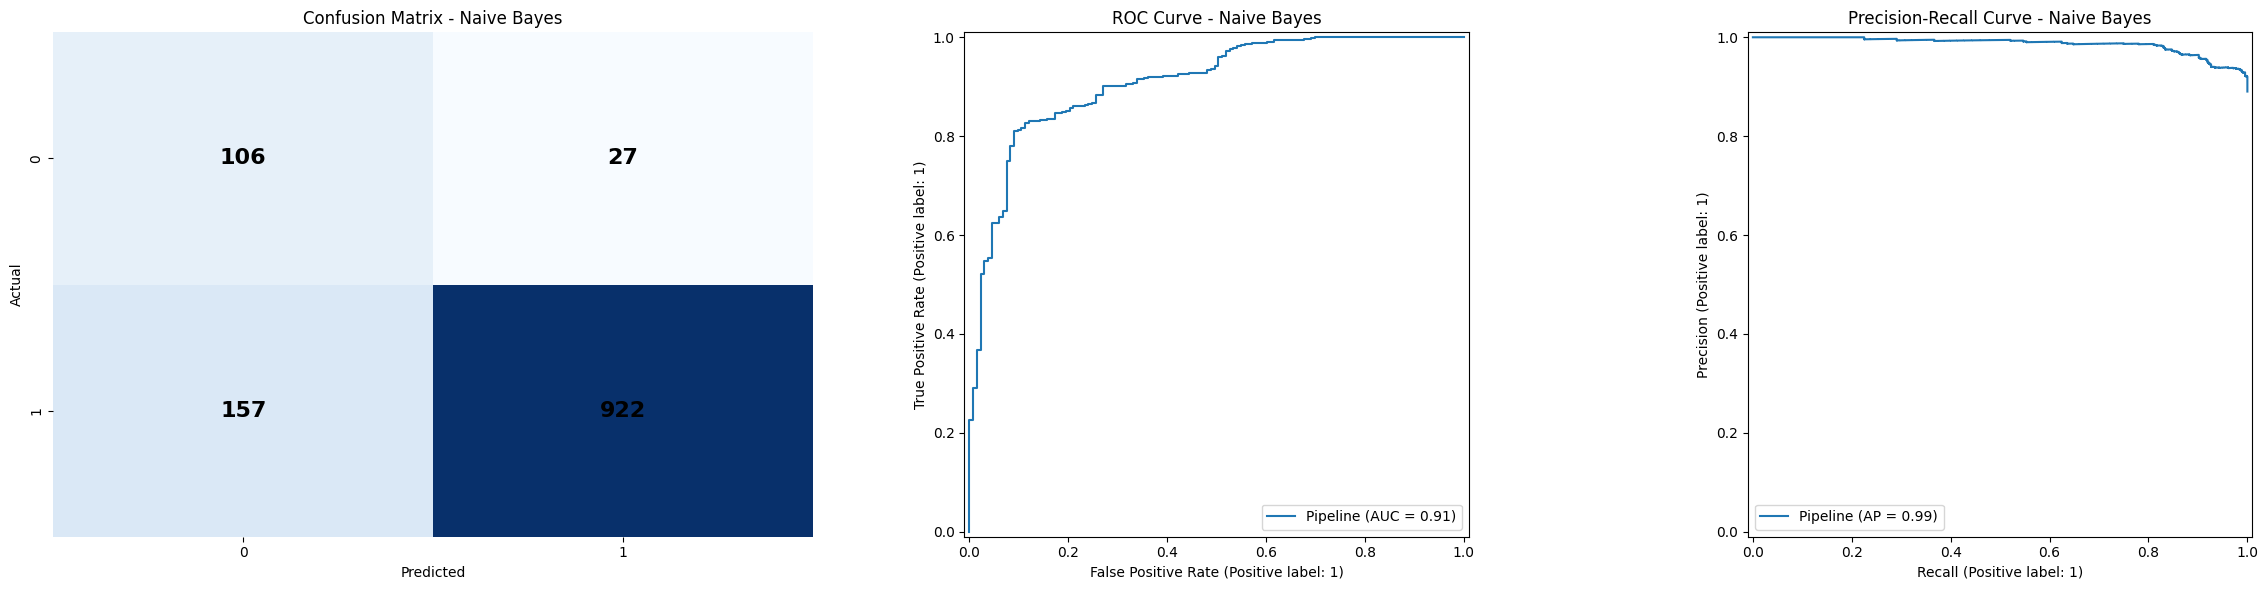

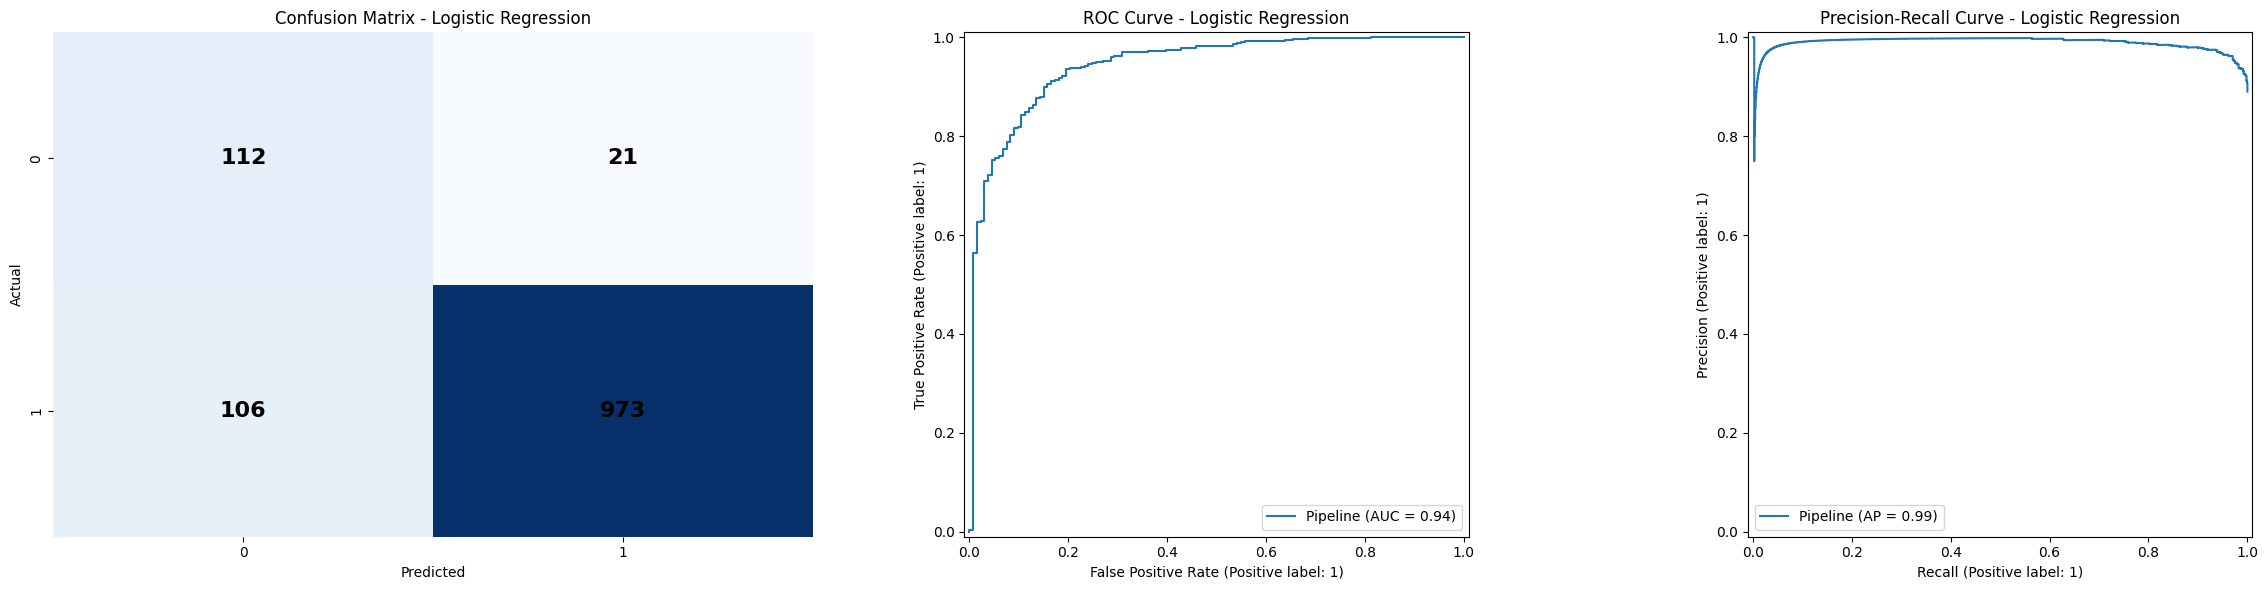

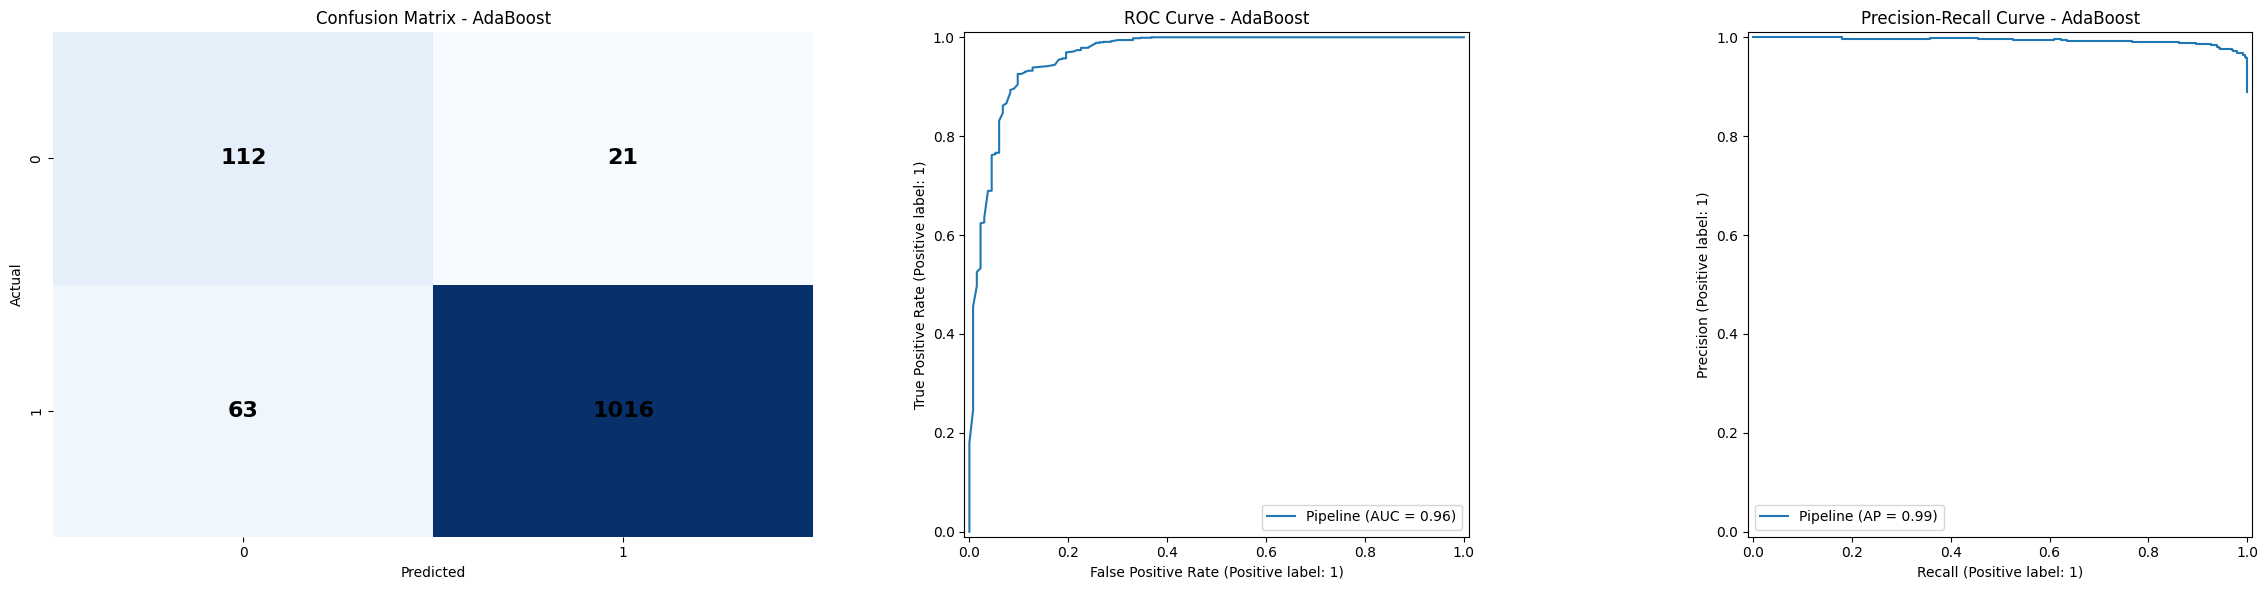

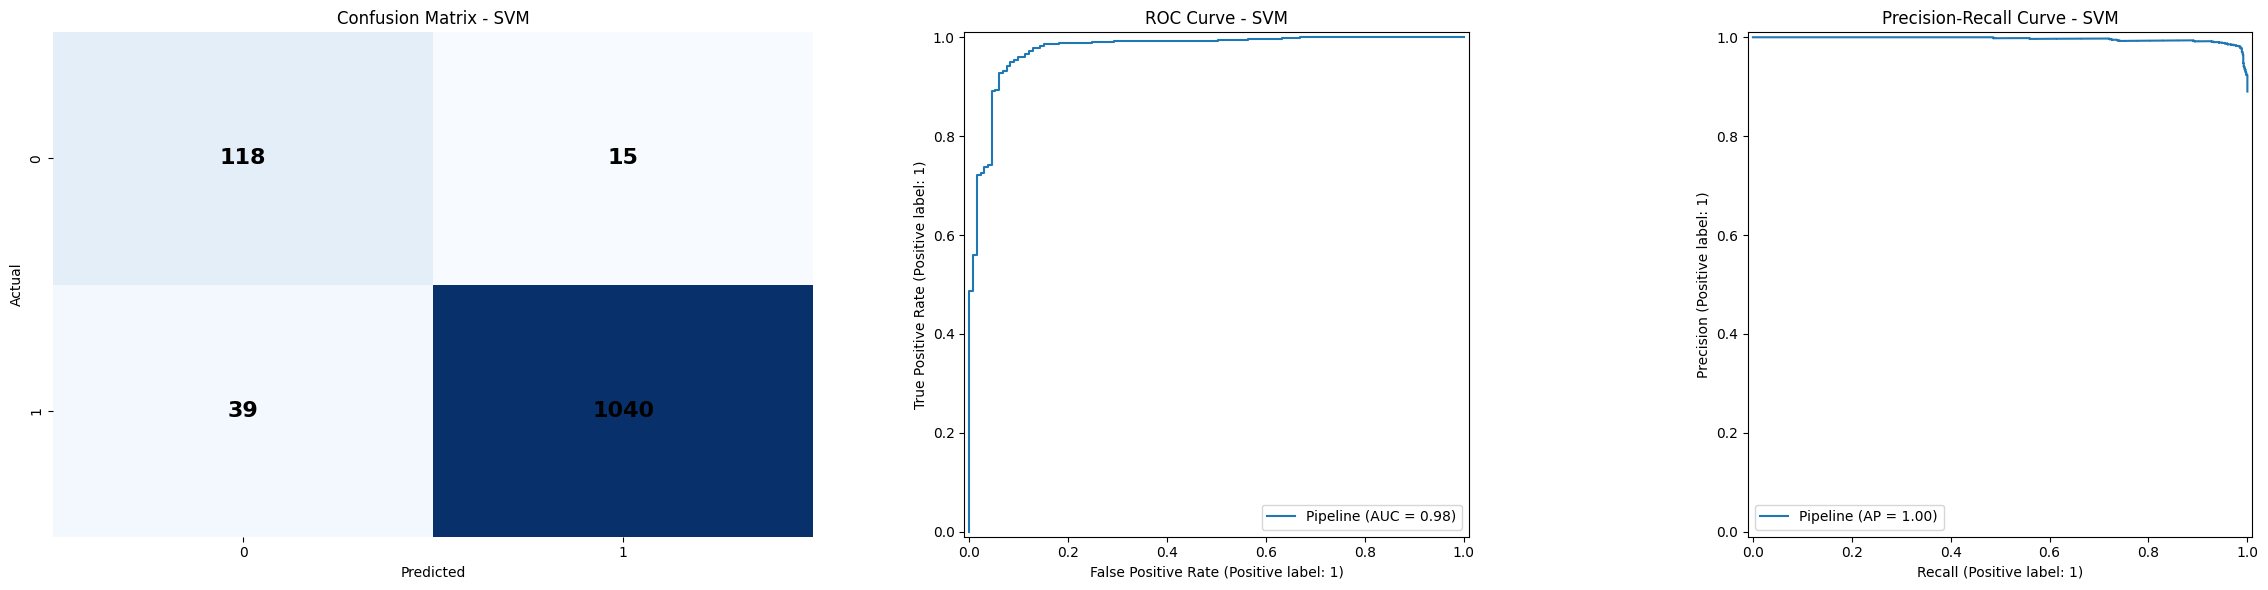

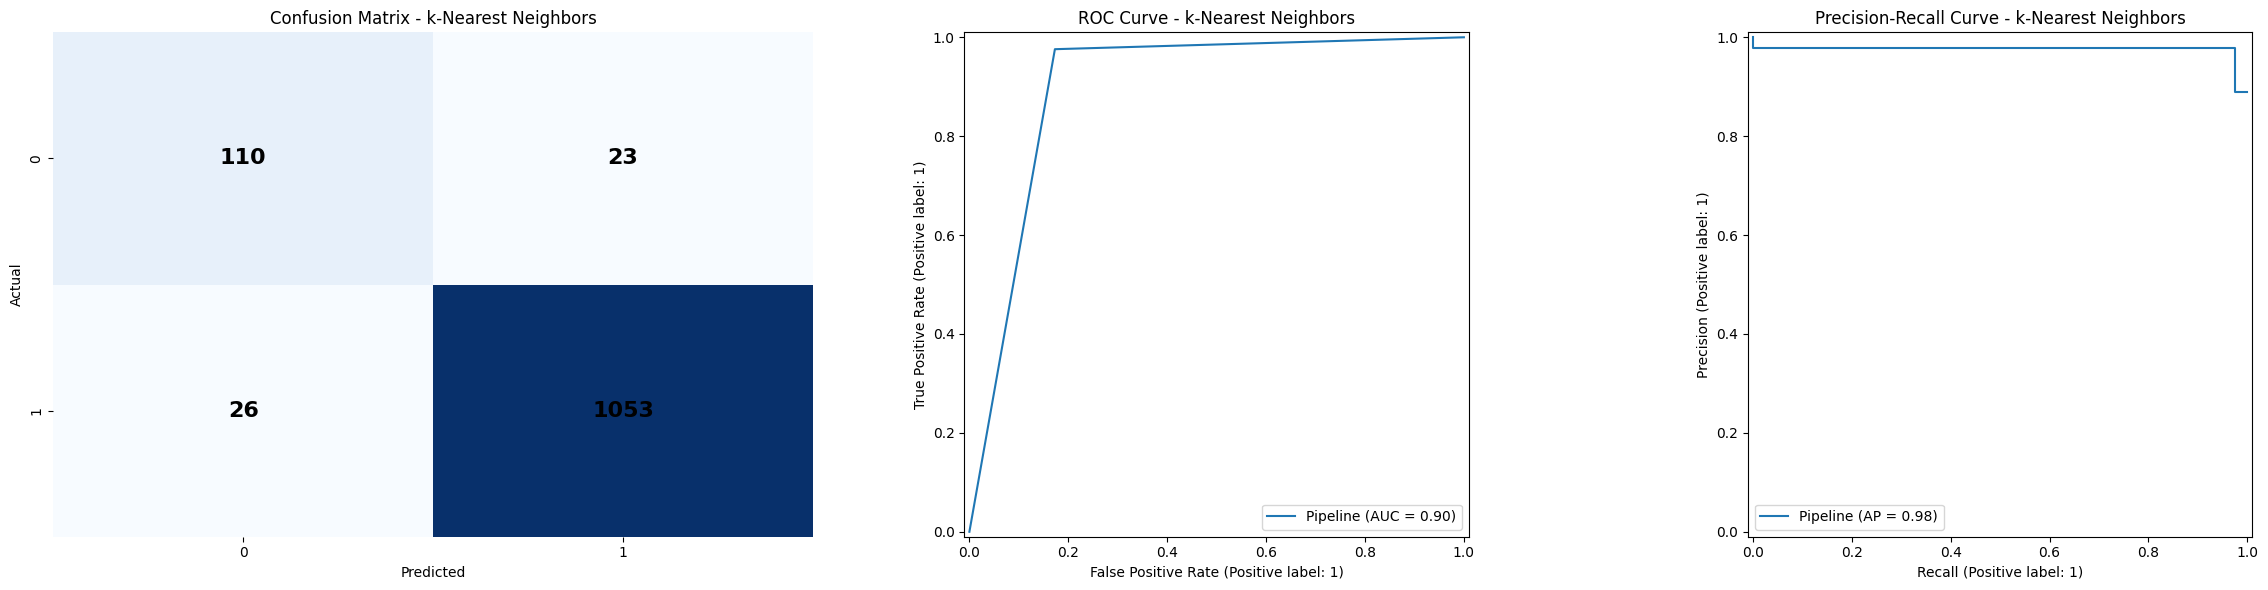

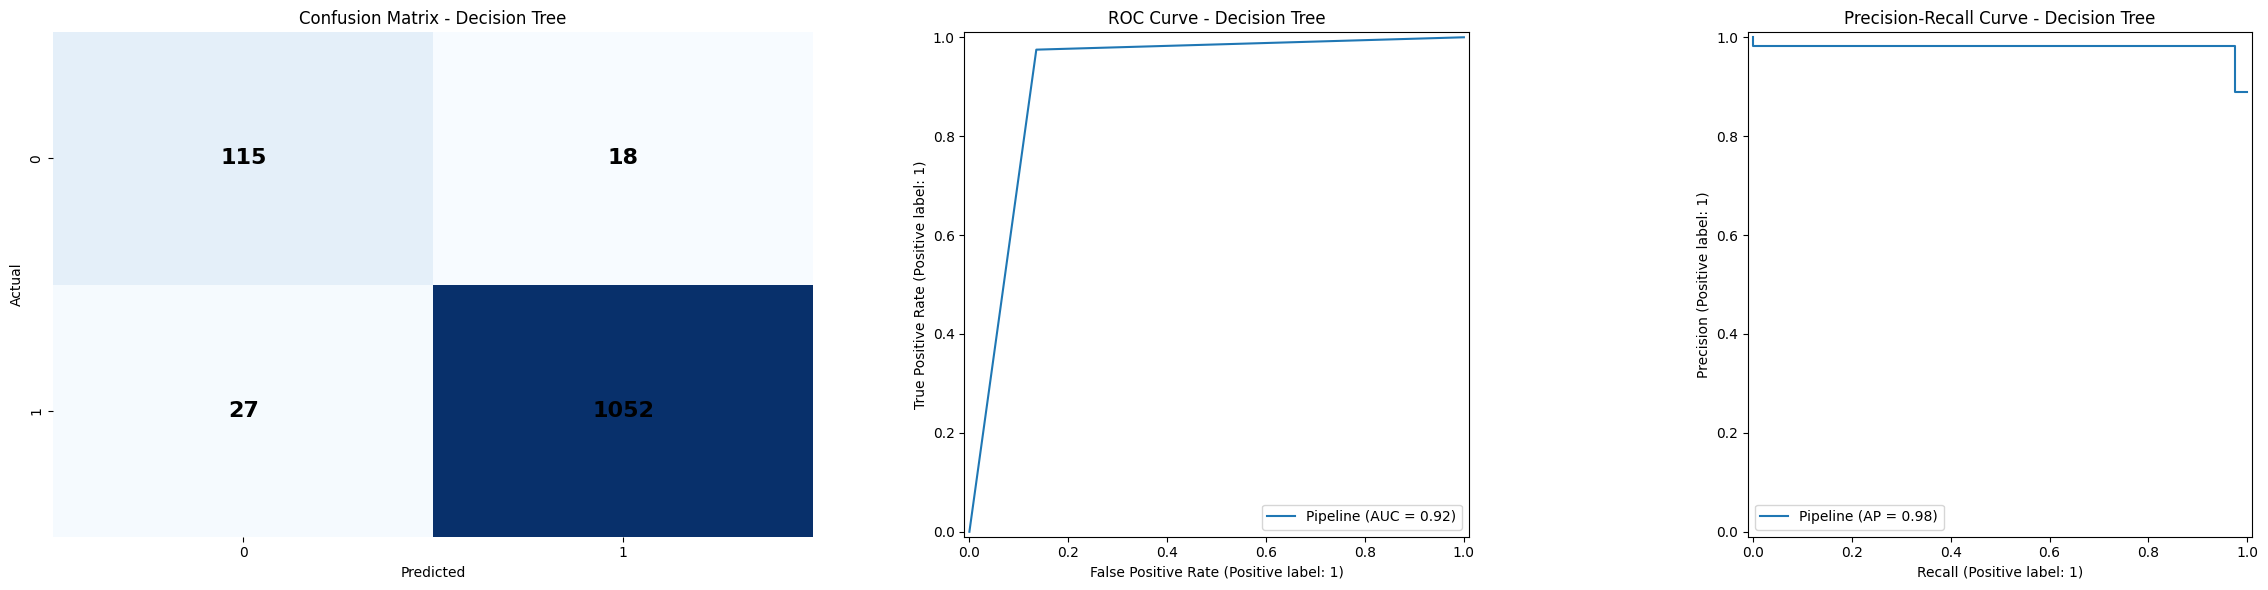

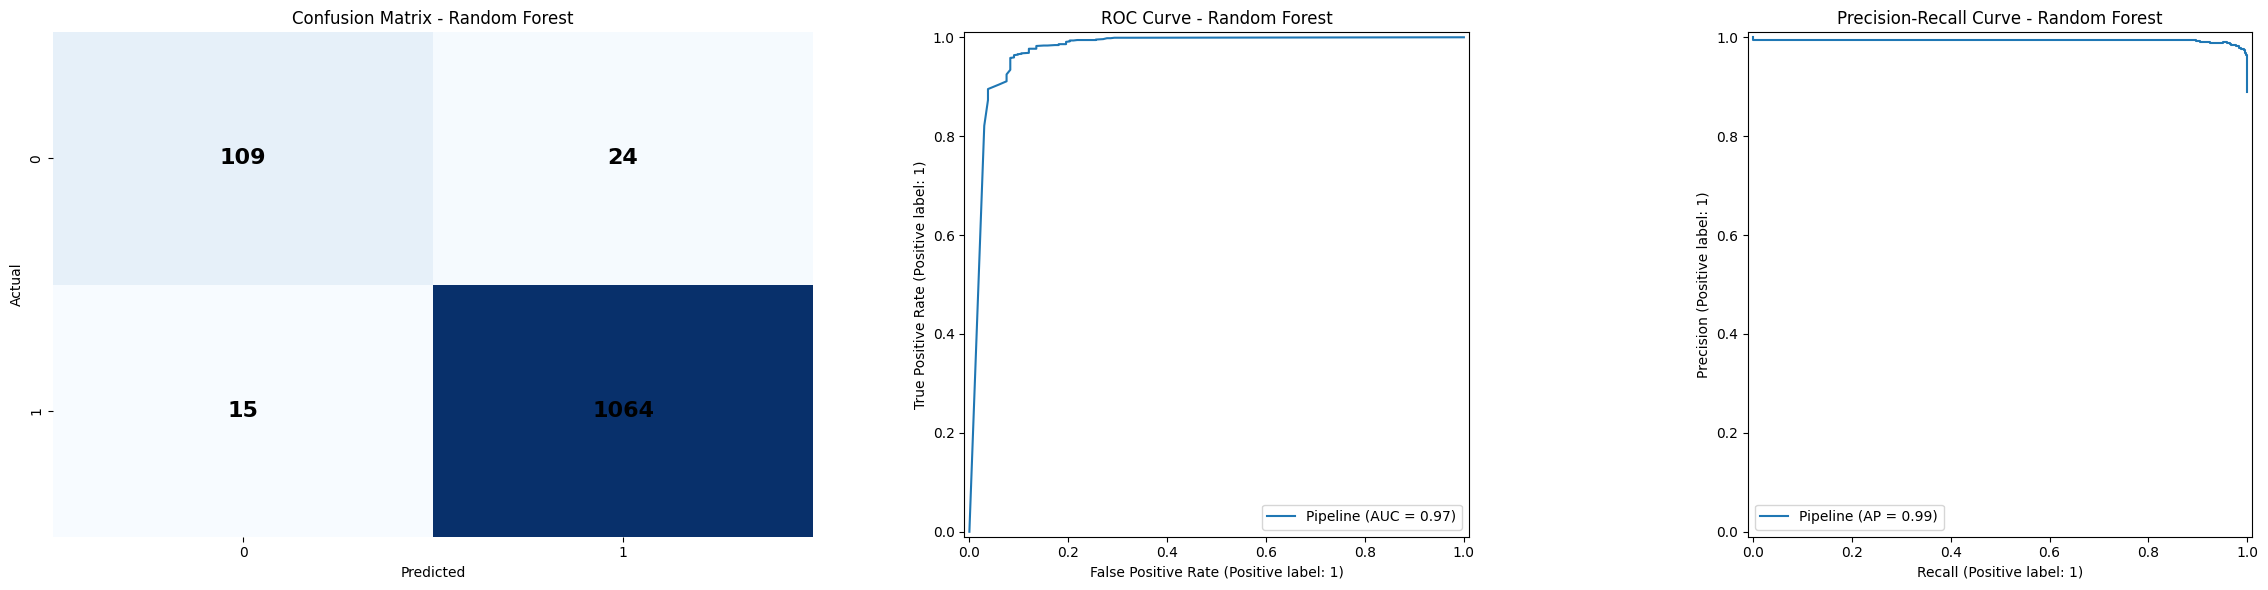

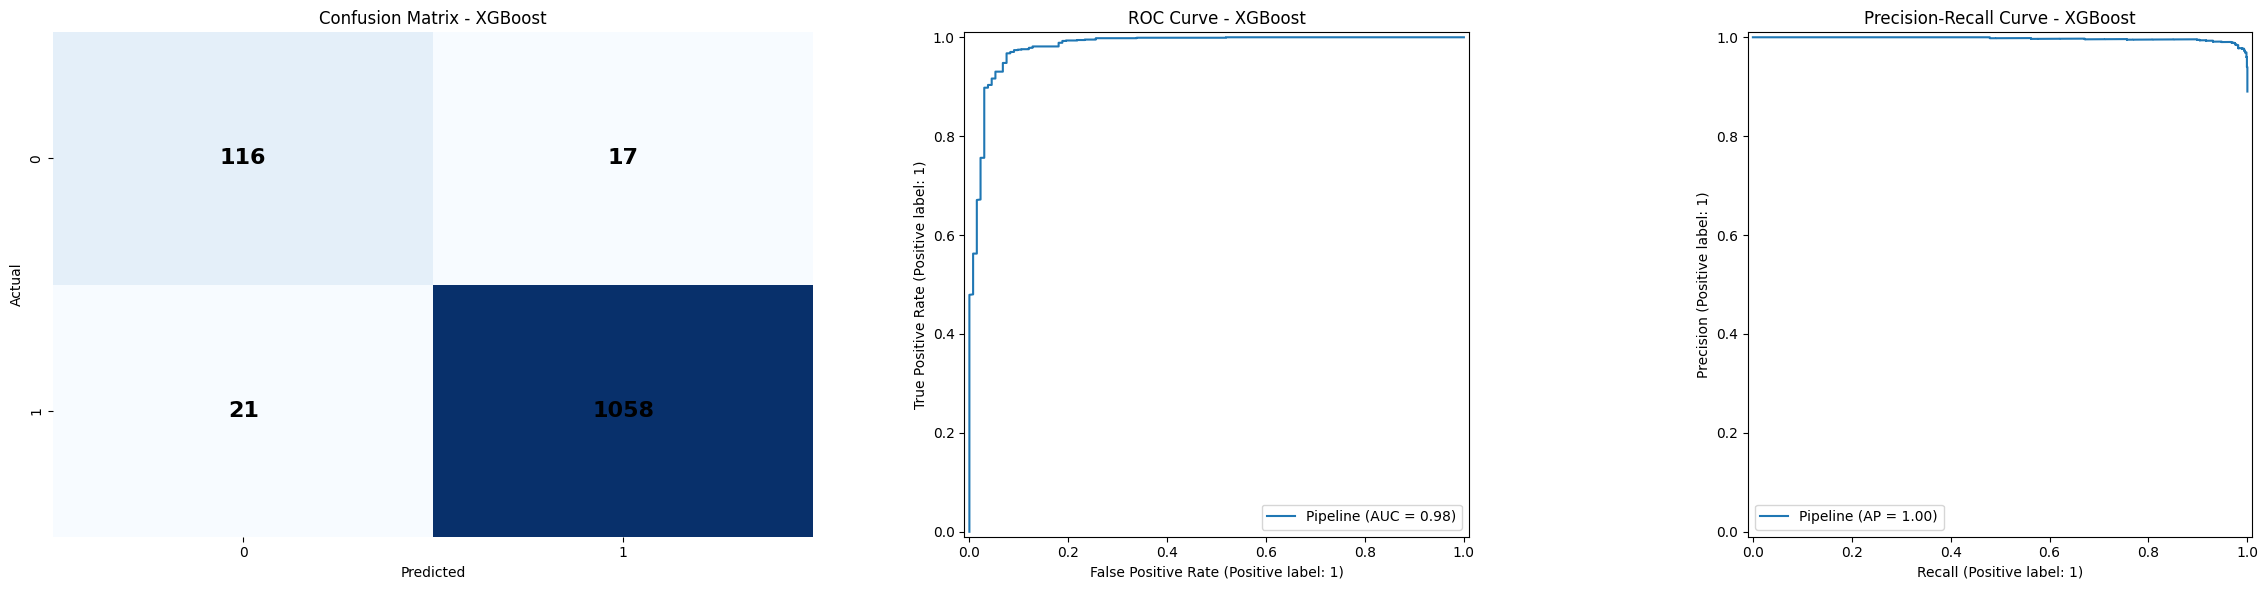

In [70]:
# Generate visualizations for each best model
for model_name, model_info in best_estimators.items():
    best_model = model_info['best_estimator']
    test_pred = best_model.predict(X_test)

    fig, ax = plt.subplots(1, 3, figsize=(24, 6))

    # Confusion Matrix Heatmap
    conf_matrix = confusion_matrix(y_test, test_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['0', '1'], columns=['0', '1'])

    sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False, annot_kws={"size": 16, "weight": "bold", "color": "black"})
    ax[0].set_title(f'Confusion Matrix - {model_name}')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')

    # ROC Curve
    roc_display = RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax[1])
    roc_display.ax_.set_title(f'ROC Curve - {model_name}')

    # Precision-Recall Curve
    pr_display = PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test, ax=ax[2])
    pr_display.ax_.set_title(f'Precision-Recall Curve - {model_name}')

    plt.tight_layout()
    plt.savefig(f'../images/performance-metrics-{model_name}.png', bbox_inches='tight')
    plt.show()

**Naive Bayes**

<u>Confusion Matrix:</u> The Naive Bayes model has difficulty correctly identifying fake profiles, resulting in 157 false negatives, which indicates that these fake profiles were classified as real. This suggests the model may not be sufficiently sensitive to subtle features distinguishing fake profiles from real ones.

<u>ROC Curve:</u> With an AUC of 0.91, the model demonstrates good overall capability in distinguishing between real and fake profiles. However, its performance might not be optimal in scenarios requiring high recall for fake profiles.

<u>Precision-Recall Curve:</u> The model achieves a high average precision (AP) of 0.99, meaning it is highly precise when predicting fake profiles. Nonetheless, the drop in recall indicates that it may miss a significant number of fake profiles, which could be detrimental in critical applications.

**Conclusion:** While the Naive Bayes model shows strong precision, its limitations in recall and the high number of false negatives suggest it may not be the best choice for detecting fake profiles where identifying all possible threats is crucial. Further optimization or alternative models should be considered to improve recall and reduce false negatives.

**Logistic Regression**

<u>Confusion Matrix:</u> The Logistic Regression model performs relatively well, correctly identifying most real and fake profiles. However, it misclassifies 106 fake profiles as real, indicating a trade-off between precision and recall.

<u>ROC Curve:</u> With an AUC of 0.94, the model demonstrates strong discrimination between real and fake profiles, suggesting it effectively balances true positives and false positives.

<u>Precision-Recall Curve:</u> The model achieves a high average precision (AP) of 0.99, indicating that when it predicts a profile as fake, it is almost always correct. However, the slight drop in recall shows that some fake profiles are still missed.

**Conclusion:** Logistic Regression provides a strong balance between precision and recall, with high overall accuracy and AUC. While it misses some fake profiles, its consistent performance across metrics makes it a reliable model for this task, especially in contexts where high precision is more critical than recall. Further refinement or combination with other models could enhance recall for even better results.

**Ada Boost**

<u>Confusion Matrix:</u> The AdaBoost model demonstrates a solid performance, correctly identifying the majority of both real and fake profiles. It misclassifies 63 fake profiles as real, indicating a better trade-off between false positives and false negatives compared to other models.

<u>ROC Curve:</u> With an AUC of 0.96, the AdaBoost model shows excellent ability to distinguish between real and fake profiles, with a strong balance between true positive and false positive rates.

<u>Precision-Recall Curve:</u> The model achieves a high average precision (AP) of 0.99, indicating that it is highly reliable when predicting profiles as fake. The curve remains high, showing a minimal drop in precision as recall increases.

**Conclusion:** The AdaBoost model provides an impressive balance between precision and recall, outperforming simpler models. Its high accuracy and AUC make it a reliable choice for detecting fake profiles, with a reduced risk of false positives compared to Logistic Regression. This model is particularly suitable for applications where the cost of false positives is significant, and high precision is required.

**Support Vector Machines (SVM)**

<u>Confusion Matrix:</u> The SVM model demonstrates strong performance, correctly identifying a high number of both real and fake profiles, with only 39 fake profiles misclassified as real. This indicates a well-balanced model with low misclassification rates.

<u>ROC Curve:</u> With an AUC of 0.98, the SVM model shows excellent discriminatory power, effectively distinguishing between real and fake profiles. The curve approaches the top-left corner, reflecting the model’s high true positive rate and low false positive rate.

<u>Precision-Recall Curve:</u> The Precision-Recall Curve is outstanding, with an average precision (AP) of 1.00, indicating near-perfect precision and recall across all thresholds, meaning the model is exceptionally reliable when predicting fake profiles.

**Conclusion:** The SVM model exhibits superior performance, with minimal errors and high precision and recall. Its effectiveness in distinguishing real from fake profiles makes it a strong candidate for deployment in scenarios where both accuracy and reliability are critical. The model’s ability to maintain high performance across various metrics underscores its robustness in this application.

**k-Nearest Neighbors (k-NN)**

<u>Confusion Matrix:</u> The k-Nearest Neighbors (k-NN) model shows a strong performance, correctly classifying a majority of both real and fake profiles. It has only 26 fake profiles misclassified as real, indicating that the model effectively captures the underlying patterns of the data.

<u>ROC Curve:</u> The ROC curve, with an AUC of 0.90, demonstrates that the k-NN model has a strong ability to differentiate between real and fake profiles, although there is slight room for improvement in certain thresholds.

<u>Precision-Recall Curve:</u> The Precision-Recall curve, with an average precision (AP) of 0.98, highlights the model’s excellent performance in identifying fake profiles, with high precision and recall rates across different thresholds.

**Conclusion:** The k-NN model performs robustly in detecting fake profiles, with a good balance between precision and recall. Although it slightly trails behind models like SVM, it still represents a reliable option, especially in scenarios where simplicity and interpretability are prioritized.

**Decision Tree**

<u>Confusion Matrix:</u> The Decision Tree model correctly identifies a large majority of both real and fake profiles, with only 27 fake profiles misclassified as real. This suggests a strong ability to generalize from the training data, capturing important patterns in the features.

<u>ROC Curve:</u> The ROC curve, with an AUC of 0.92, indicates that the Decision Tree model has a solid performance in distinguishing between real and fake profiles. The model is particularly effective in maintaining a low false-positive rate.

<u>Precision-Recall Curve:</u> The Precision-Recall curve, with an average precision (AP) of 0.98, highlights the model’s high precision and recall, especially in handling imbalanced datasets where fake profiles might be the minority class.

**Conclusion:** The Decision Tree model exhibits strong performance in detecting fake profiles, with high precision and recall. It is a reliable model with a good balance of accuracy and interpretability, making it a valuable tool in identifying deceptive profiles. However, it may benefit from further tuning or ensembling with other models to improve robustness.

**Random Forest**

<u>Confusion Matrix:</u> The Random Forest model shows exceptional performance, correctly identifying most fake and real profiles. It misclassifies only 15 fake profiles as real, indicating a robust generalization capability across diverse data patterns.

<u>ROC Curve:</u> The ROC curve with an AUC of 0.97 signifies that the Random Forest model is highly effective in distinguishing between real and fake profiles, with a strong performance across various thresholds.

<u>Precision-Recall Curve:</u> The Precision-Recall curve, showing an average precision (AP) of 0.99, highlights the model’s ability to handle imbalanced classes effectively, maintaining high precision and recall in detecting fake profiles.

**Conclusion:** The Random Forest model is highly effective, with excellent precision and recall, making it one of the top-performing models in this task. Its balance between accuracy and robustness makes it a strong candidate for deployment in detecting fake profiles.

**XGBoost**

<u>Confusion Matrix:</u> The XGBoost model shows strong performance, accurately predicting 116 real profiles and 1,058 fake profiles. It misclassifies only 21 fake profiles as real and 17 real profiles as fake, indicating a high level of precision and recall.

<u>ROC Curve:</u> The ROC curve with an AUC of 0.98 suggests that XGBoost is highly effective at distinguishing between real and fake profiles across various thresholds.

<u>Precision-Recall Curve:</u> With an average precision (AP) of 1.00, the Precision-Recall curve demonstrates XGBoost's superior ability to maintain high precision and recall, particularly in handling class imbalances.

**Conclusion:** XGBoost exhibits exceptional performance in detecting fake profiles, with both high accuracy and precision. Its ability to minimize misclassification while maintaining efficiency makes it one of the best choices for deployment in a production environment.

**Conclusion on the Best Model**

After evaluating multiple models, **XGBoost** emerges as the top performer for detecting fake profiles in the dataset. It achieves an impressive balance between accuracy, precision, recall, and F1 score, with an Area Under the Curve (AUC) of 0.98. This indicates that XGBoost has a strong ability to distinguish between real and fake profiles, making it highly reliable for this classification task.

**Random Forest** also delivers excellent performance, with a slightly lower AUC but still high accuracy and recall, suggesting it is a solid alternative to XGBoost. It is particularly noteworthy for its robustness and consistency across different evaluation metrics.

**SVM (Support Vector Machine)** performs very well, particularly in terms of AUC (0.98), but it falls slightly short of XGBoost and Random Forest in terms of precision. This makes it less suitable for cases where minimizing false positives is critical.

Overall, XGBoost is recommended as the best model due to its superior performance and efficiency, making it ideal for real-time detection of fake profiles. Its strong generalization capabilities ensure that it can handle a wide range of data variations, which is crucial in dynamic environments like social networks.

### **Visualize Feature Importance from the best models**

The following code visualizes feature importance for each model in a grid of subplots. It iterates over the best models, extracting feature importances or coefficients (for logistic regression) and plotting them horizontally. The `plot_feature_importance` function sorts features by importance and labels the axes accordingly. Unused subplots are hidden to ensure a clean layout. This approach allows easy comparison of feature importance across different models, helping to identify which features are most influential in making predictions.

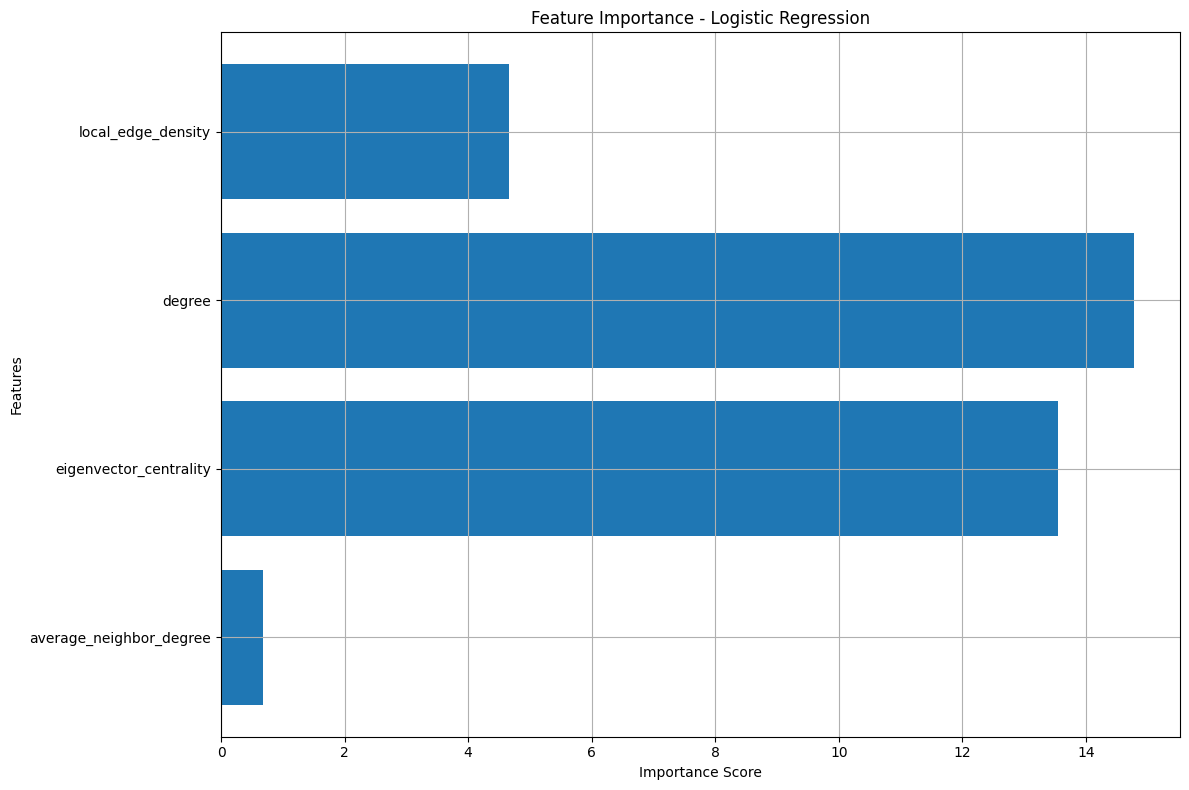

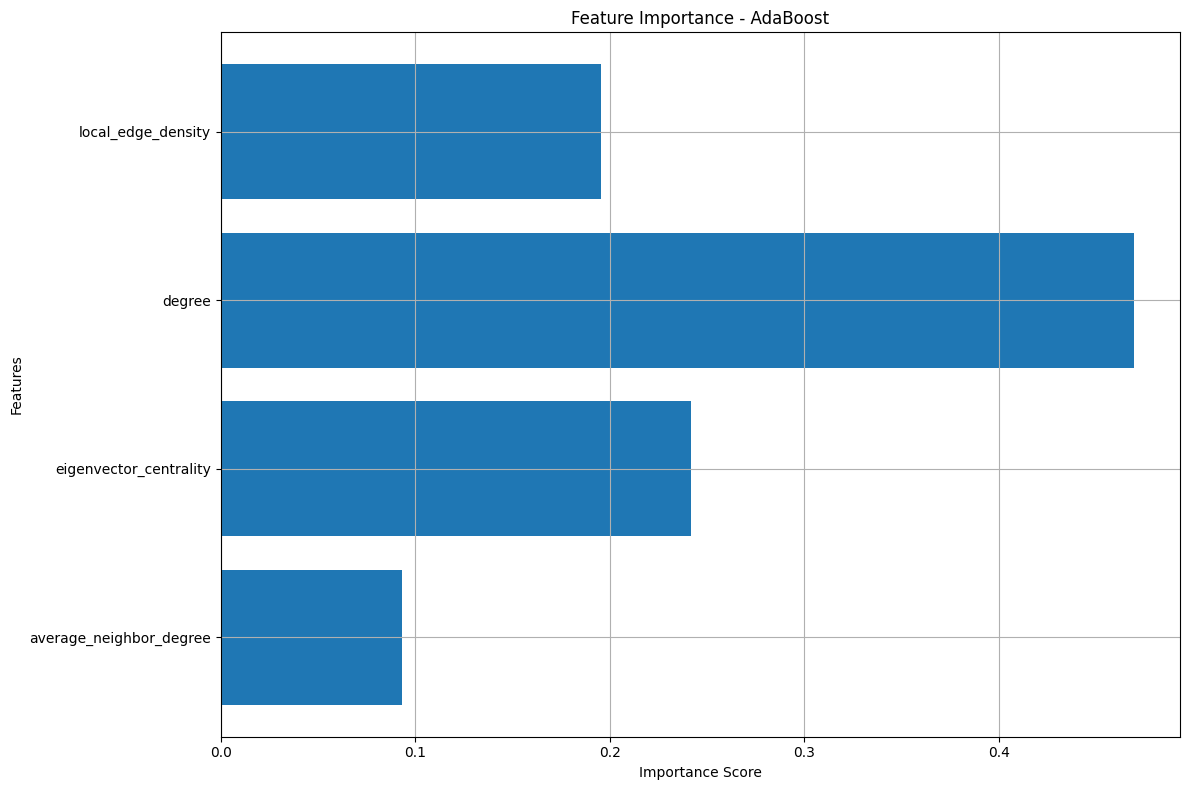

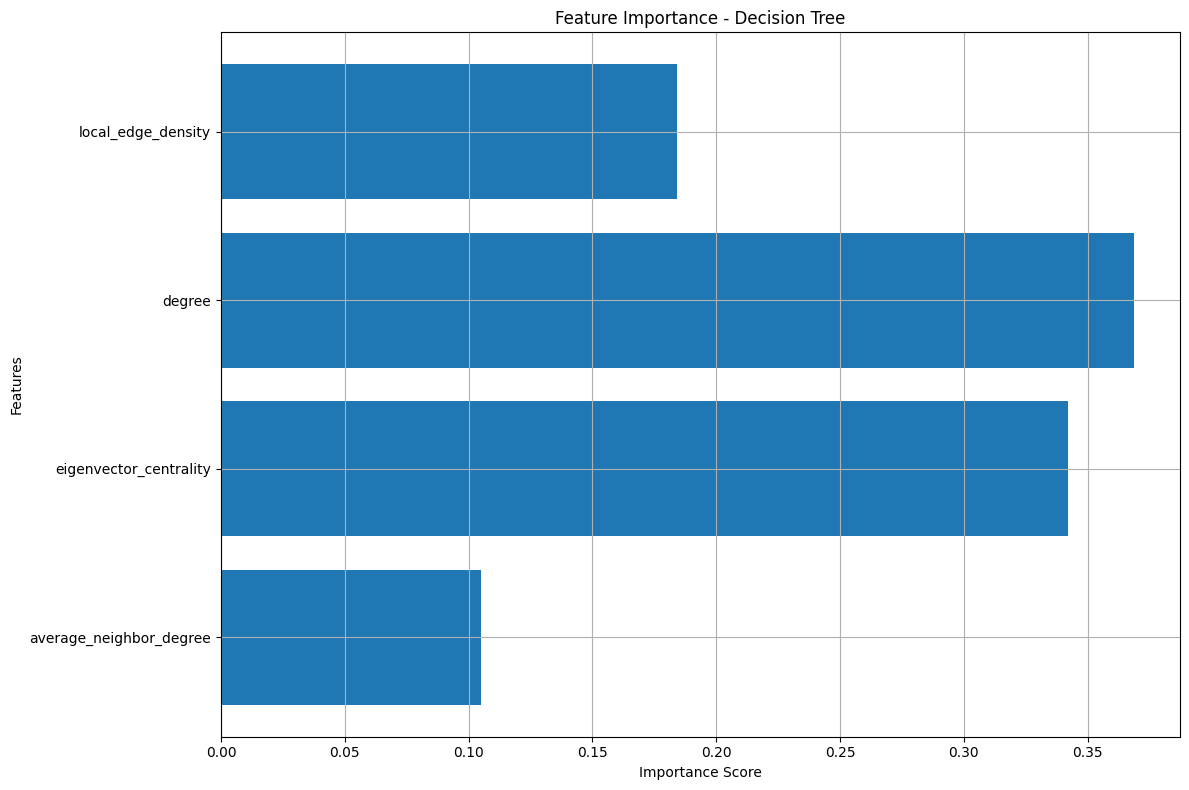

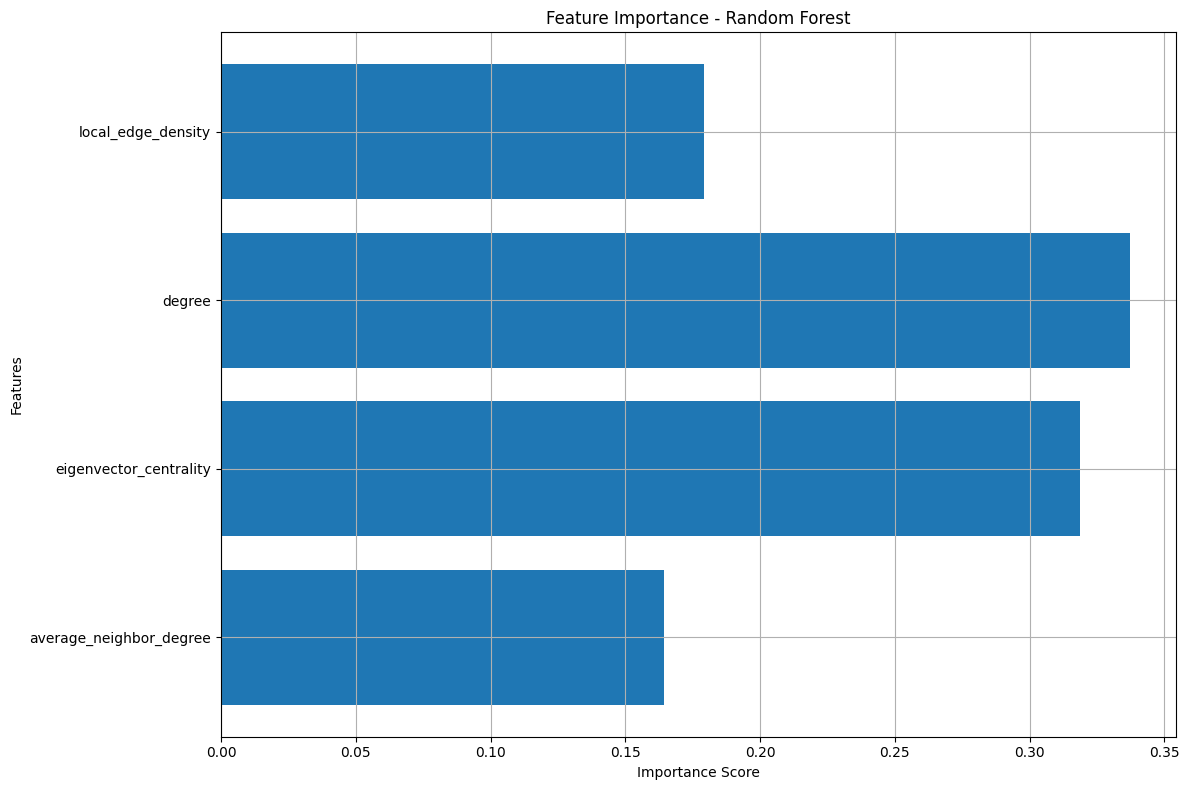

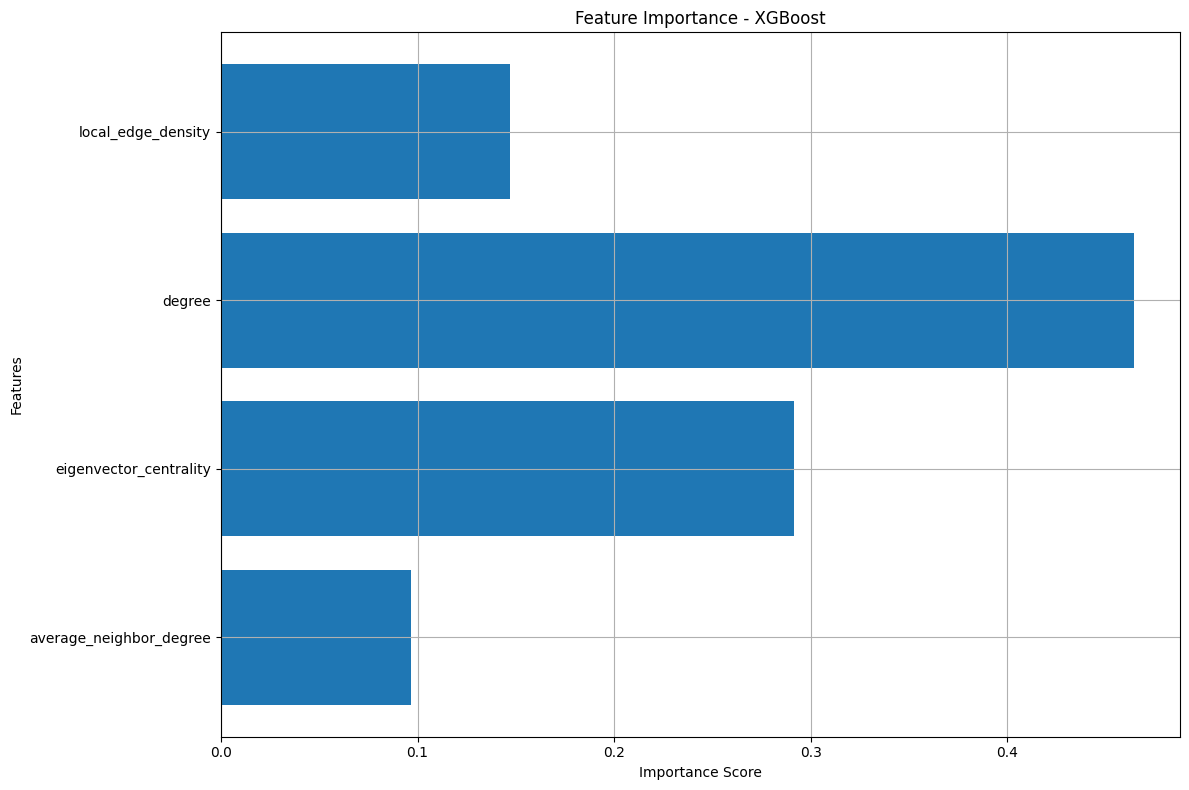

In [71]:
# Initialize a DataFrame to collect importances from all models
feature_importance_df = pd.DataFrame(index=X.columns)

# Function to collect feature importance
def collect_feature_importance(importance, feature_names, model_name):
    feature_importance_df[model_name] = importance

# Collect feature importances from each best model
for model_name, model_info in best_estimators.items():
    best_model = model_info['best_estimator']

    # Check if the model has feature importances
    if hasattr(best_model['classifier'], 'feature_importances_'):
        importance = best_model['classifier'].feature_importances_
        collect_feature_importance(importance, X.columns, model_name)

    # For logistic regression, use the coefficients as feature importance
    elif model_name == 'Logistic Regression':
        importance = np.abs(best_model['classifier'].coef_[0])
        collect_feature_importance(importance, X.columns, model_name)

# Fill any missing values with 0 (for models without feature importance)
feature_importance_df.fillna(0, inplace=True)

# Plot the feature importance separately for each model
for model_name in feature_importance_df.columns:
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(X.columns)), feature_importance_df[model_name], align='center')
    plt.yticks(range(len(X.columns)), X.columns)
    plt.title(f'Feature Importance - {model_name}')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'../images/feature-importance-{model_name}.png', bbox_inches='tight')
    plt.show()


The feature importance charts for the different models—AdaBoost, Decision Tree, Logistic Regression, Random Forest, and XGBoost—reveal some key insights about the models' behavior and the influence of various features on predicting whether a profile is fake or not:

**Degree** is consistently the most important feature across all models. This suggests that the number of connections a user has is a significant indicator of whether a profile is real or fake.

**Eigenvector Centrality** and **Local Edge Density** also play important roles across most models, indicating that the network influence and the local neighborhood structure are critical in distinguishing real profiles from fake ones.

**Average Neighbor Degree** has a lower importance score across models, implying it has less predictive power relative to the other features.

**Logistic Regression** shows larger importance values overall, which is expected since it’s based on coefficients that can be more sensitive to feature scaling.

In summary, the charts indicate that network-related features, particularly those related to connectivity and influence, are crucial in detecting fake profiles. Degree stands out as the dominant feature, suggesting models that account for network centrality and connectivity are likely to perform well in this classification task.

## **Modeling using Deep Learning Alogrithms**

### **Convert NetworkX Graph to PyTorch Geometric Data**

The following code is designed to prepare a graph dataset for use in PyTorch Geometric. It reads an edge list from the dataset file, creates a NetworkX graph, and converts it to an edge index suitable for PyTorch Geometric. The graph is treated as undirected by including both directions for each edge. Node features and labels are extracted from the `features_df` dataframe and converted to tensors.

In [22]:
# Load the dataset
edges = pd.read_csv('../data/facebook_combined.txt', sep=" ", header=None, names=["source", "target"])

# Create the graph
# G is the NetworkX graph
G = nx.from_pandas_edgelist(edges)

# Convert NetworkX graph to edge_index (ensure both directions for undirected graph)
edge_list = list(G.edges)
edge_list += [(v, u) for u, v in edge_list]  # Add reverse direction for each edge
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

# features_df is the dataframe with features and labels
# Convert node features and labels to tensors
node_features = torch.tensor(features_df.drop(columns=['is_real']).values, dtype=torch.float)
node_labels = torch.tensor(features_df['is_real'].astype('category').cat.codes.values, dtype=torch.long)

# Create PyTorch Geometric data object
data = Data(x=node_features, edge_index=edge_index, y=node_labels)

# Split the data into training and testing sets
train_indices, test_indices = train_test_split(range(data.num_nodes), test_size=0.2, random_state=42)

# Create masks
train_mask = torch.tensor(train_indices, dtype=torch.long)
test_mask = torch.tensor(test_indices, dtype=torch.long)

# 'is_real' is the target label
num_classes = len(set(features_df['is_real']))

print(data)
print('=======================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of classes: {num_classes}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {train_mask.size(0)}')
print(f'Training node label rate: {train_mask.size(0) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[4039, 4], edge_index=[2, 176468], y=[4039])
Number of nodes: 4039
Number of edges: 176468
Number of classes: 2
Average node degree: 43.69
Number of training nodes: 3231
Training node label rate: 0.80
Has isolated nodes: False
Has self-loops: False
Is undirected: True


The `Data` object is created, containing the node features (`x`), edge index (`edge_index`), and labels (`y`). This `Data` object is now ready to be used for graph neural network models in PyTorch Geometric.

### **Using GAT Model**

The following code implements a Graph Attention Network (GAT) for node classification in a graph. The GAT model uses attention mechanisms to assign different importance to different neighboring nodes during the message-passing process. Key aspects of the code include:

<u>Model Definition:</u> The GAT model uses attention mechanisms to assign different weights to neighboring nodes, allowing it to focus on the most relevant neighbors during aggregation.This model consists of two `GATConv` layers. The first layer applies multi-head attention (with `num_heads` attention heads) followed by an `ELU` activation function, to learn hidden features, while the second layer aggregates these features into class predictions. A dropout layer is included to prevent overfitting by randomly deactivating some neurons during training.  The final output is a `log-softmax` layer, providing class probabilities for each node.

<u>Data Splitting:</u> The dataset is split into training and testing sets, with the training set used to optimize the model's parameters and the testing set used to evaluate its generalization performance.

<u>Training Loop:</u> The training loop runs for 1,000 epochs. During each epoch, the model performs forward propagation to compute the output, calculates the loss using cross-entropy, and then backpropagates the gradients to update the model's parameters using the `Adam` optimizer.

<u>Performance Tracking:</u> Training loss and accuracy, as well as testing accuracy, are recorded at regular intervals (every 10 epochs). The final performance metrics and training time are printed.

<u>Visualization:</u> The accuracy and loss are plotted over epochs to visualize the model's training process, helping to identify potential issues like overfitting or underfitting.

This implementation provides a robust framework for training and evaluating a GAT model on node classification tasks.

Final Epoch 1000, Loss: 0.3043, Train Accurracy: 0.9041, Test Accurracy: 0.9047


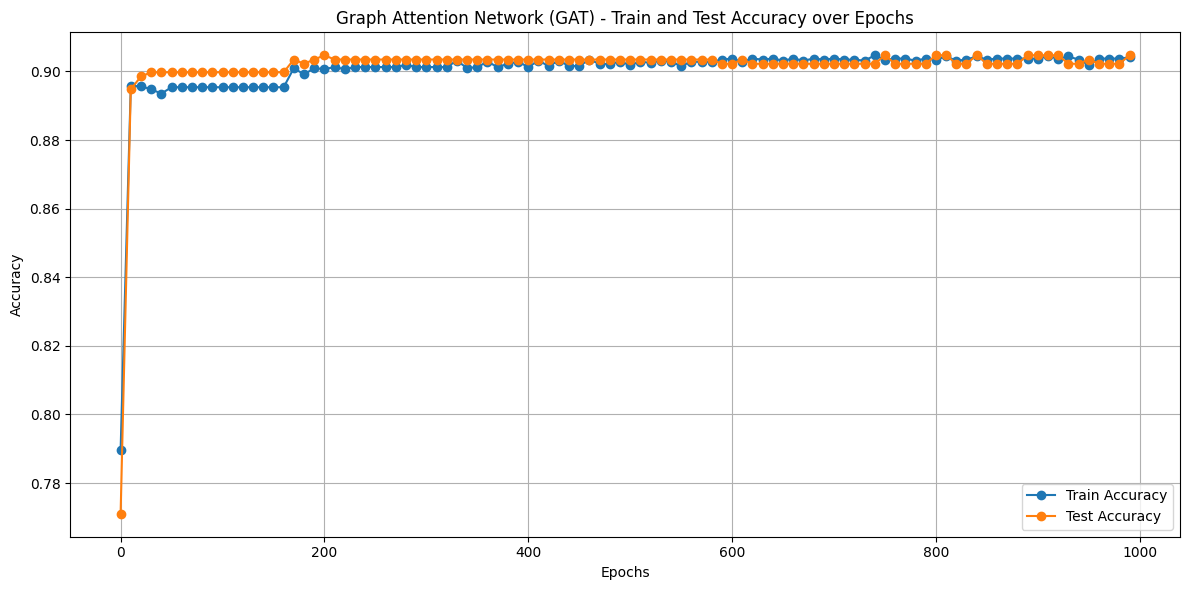

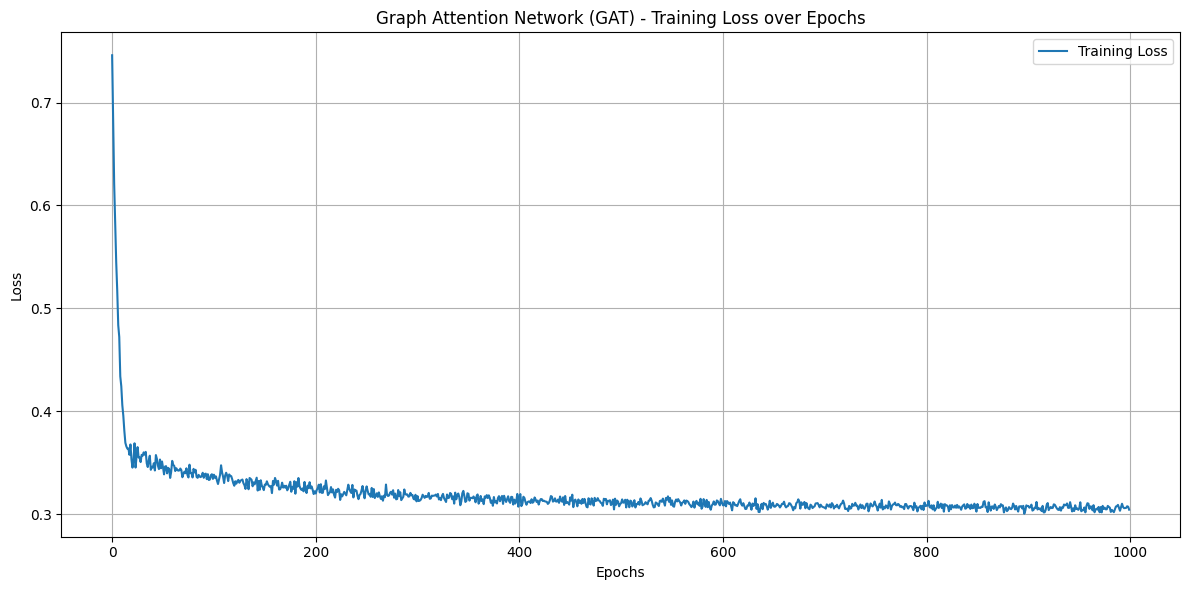

In [23]:
class GAT(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_dim=8, num_heads=8, dropout_rate=0.6):
        super(GAT, self).__init__()
        self.gat1 = GATConv(num_node_features, hidden_dim, heads=num_heads, dropout=dropout_rate)
        self.gat2 = GATConv(hidden_dim * num_heads, num_classes, heads=1, concat=False, dropout=dropout_rate)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # First GAT layer with activation function
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        
        # Optional dropout
        x = self.dropout(x)
        
        # Second GAT layer
        x = self.gat2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

# Split the data into training and testing sets
train_indices, test_indices = train_test_split(range(data.num_nodes), test_size=0.2, random_state=42)

# Create masks
train_mask = torch.tensor(train_indices, dtype=torch.long)
test_mask = torch.tensor(test_indices, dtype=torch.long)

# Define the model
num_classes = len(set(features_df['is_real']))
model = GAT(num_node_features=data.num_node_features, num_classes=num_classes)

# Define the loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Initialize lists to store loss and accuracy values
gat_train_losses = []
gat_train_accuracies = []
gat_test_accuracies = []

# Training loop
def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients
    out = model(data)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()  # Derive gradients
    optimizer.step()  # Update parameters based on gradients
    return loss.item()

# Testing function
def test(mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out[mask].max(dim=1)[1]
        correct = pred.eq(data.y[mask]).sum().item()
        accuracy = correct / mask.size(0)
        return accuracy

# Function to plot accuracy
def plot_accuracy(epochs, train_accuracies, test_accuracies, title):
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'../images/{title.replace(' ', '-').lower()}.png', bbox_inches='tight')
    plt.show()

# Function to plot training loss
def plot_loss(losses, title):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(losses)), losses, label='Training Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'../images/{title.replace(' ', '-').lower()}.png', bbox_inches='tight')
    plt.show()

# Training the model
gat_num_epochs = 1000
start_time = time.time()  # Start the timer
for epoch in range(gat_num_epochs):
    loss = train()
    gat_train_losses.append(loss)

    if epoch % 10 == 0:
        train_acc = test(train_mask)
        test_acc = test(test_mask)

        gat_train_accuracies.append(train_acc)
        gat_test_accuracies.append(test_acc)

end_time = time.time()  # End the timer
gat_training_time = end_time - start_time
gat_final_loss = gat_train_losses[len(gat_train_losses)-1]
gat_final_train_acc = gat_train_accuracies[len(gat_train_accuracies)-1]
gat_final_test_acc = gat_test_accuracies[len(gat_test_accuracies)-1]
print(f'Final Epoch {gat_num_epochs}, Loss: {gat_final_loss:.4f}, Train Accurracy: {gat_final_train_acc:.4f}, Test Accurracy: {gat_final_test_acc:.4f}')

# Plotting the training and testing accuracy
gat_epochs = list(range(0, gat_num_epochs, 10))
plot_accuracy(gat_epochs, gat_train_accuracies, gat_test_accuracies, 'Graph Attention Network (GAT) - Train and Test Accuracy over Epochs')

# Plotting the training loss over epochs
plot_loss(gat_train_losses, 'Graph Attention Network (GAT) - Training Loss over Epochs')

### **Using GCN Model**

The following code implements a Graph Convolutional Network (GCN) for node classification tasks using PyTorch Geometric. Key aspects of the code include:

<u>Model Definition:</u> The GCN model consists of two graph convolutional layers (`GCNConv`). The first layer transforming the input node features into a hidden dimension (default 16) and applying an activation function (default `ReLU`). A dropout layer is included for regularization. The second layer produces the final class scores. The output is passed through a `log_softmax` function, suitable for multi-class classification. The architecture is simple yet effective for learning graph-structured data, and the flexibility of hidden dimensions, activation, and dropout enhances its adaptability.  Additionally, the model's architecture is designed to learn node embeddings by aggregating features from neighboring nodes, making it effective for tasks like node classification in graph-structured data. As mentioned earlier, the dropout layer helps to regularize the model, improving its generalization to unseen data.

<u>Data Splitting:</u> The dataset is split into training and testing sets using indices, with 20% of the data reserved for testing. The masks created for the training and testing sets allow the model to focus on specific nodes during the training and evaluation phases.

<u>Training and Testing Loops:</u> The training loop runs for 1,000 epochs. For each epoch, the model computes the forward pass, calculates the loss using cross-entropy, backpropagates the gradients, and updates the model parameters using the `Adam` optimizer. Testing occurs every 10 epochs, where the model's accuracy on both training and testing sets is recorded.

<u>Performance Tracking:</u> The code tracks training loss, training accuracy, and testing accuracy over epochs. The final loss and accuracies are printed after the training is completed. The code also measures and prints the total training time.

<u>Visualization:</u> The code plots training accuracy, testing accuracy, and training loss over epochs to help visualize the model's learning process and identify potential issues like overfitting or underfitting.

This implementation provides a solid framework for training and evaluating a GCN model on node classification tasks, allowing for performance monitoring and analysis.

Final Epoch 1000, Loss: 0.2820, Train Accurracy: 0.9050, Test Accurracy: 0.9035


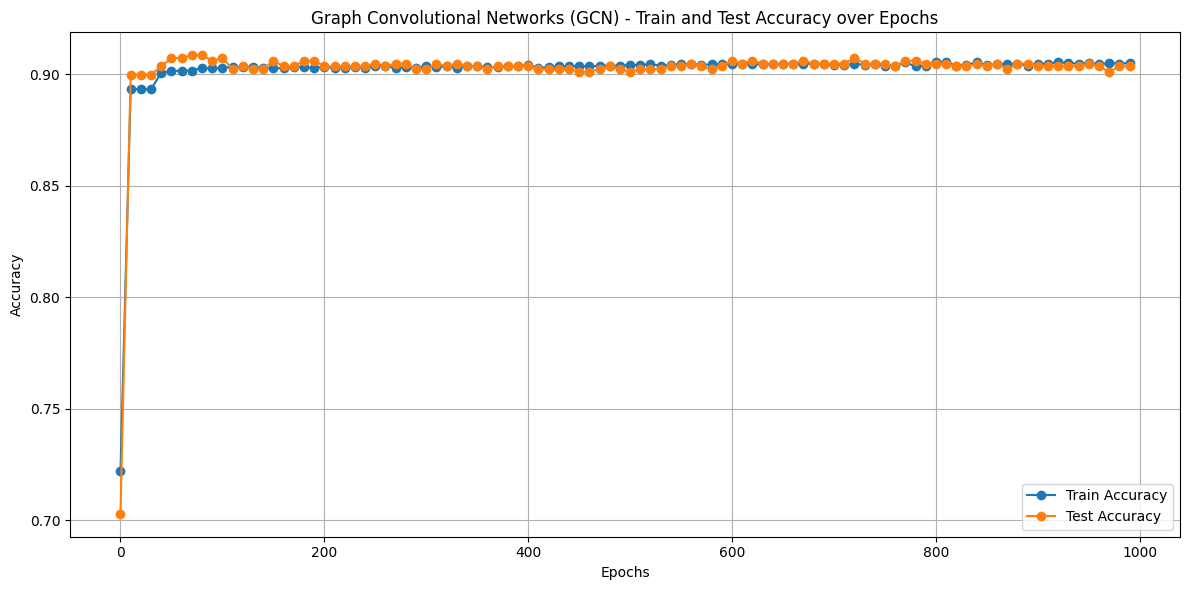

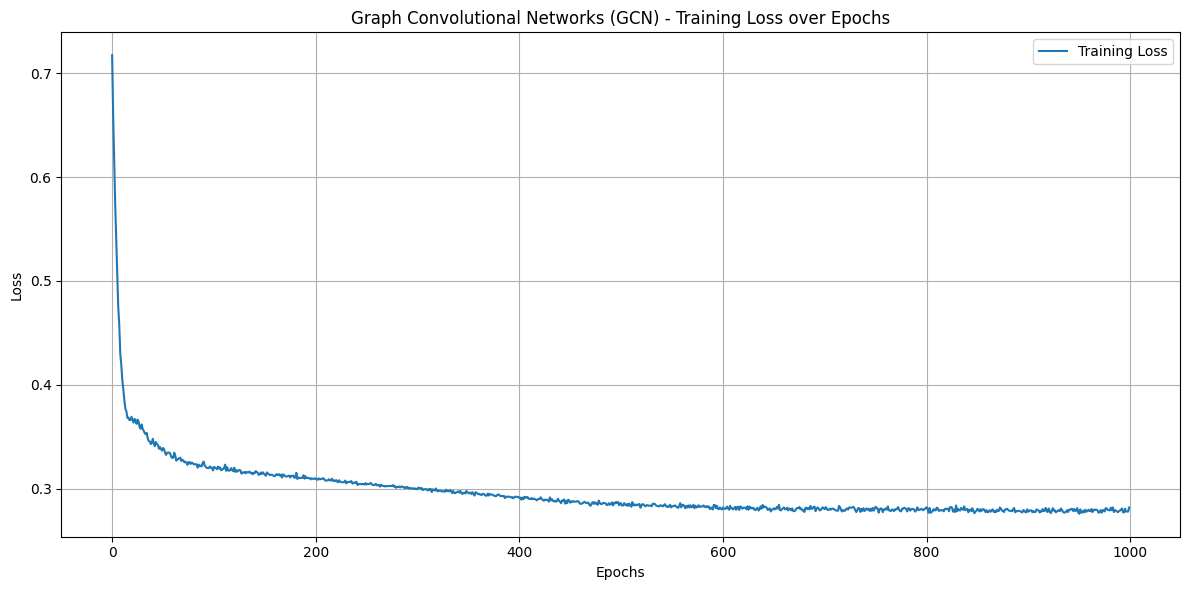

In [24]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_dim=16, activation=F.relu, dropout_rate=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)
        self.activation = activation
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # First GCN layer with activation function
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        
        # Optional dropout
        x = self.dropout(x)
        
        # Second GCN layer
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

# Split the data into training and testing sets
train_indices, test_indices = train_test_split(range(data.num_nodes), test_size=0.2, random_state=42)

# Create masks
train_mask = torch.tensor(train_indices, dtype=torch.long)
test_mask = torch.tensor(test_indices, dtype=torch.long)

# Define the model
num_classes = len(set(features_df['is_real']))
model = GCN(num_node_features=data.num_node_features, num_classes=num_classes, hidden_dim=32, activation=F.relu, dropout_rate=0.3)

# Define the loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Initialize lists to store loss and accuracy values
gcn_train_losses = []
gcn_train_accuracies = []
gcn_test_accuracies = []

# Training loop
def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients
    out = model(data)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()  # Derive gradients
    optimizer.step()  # Update parameters based on gradients
    return loss.item()

# Testing function
def test(mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out[mask].max(dim=1)[1]
        correct = pred.eq(data.y[mask]).sum().item()
        accuracy = correct / mask.size(0)
        return accuracy

# Training the model
gcn_num_epochs = 1000
start_time = time.time()  # Start the timer
for epoch in range(gcn_num_epochs):
    loss = train()
    gcn_train_losses.append(loss)

    if epoch % 10 == 0:
        train_acc = test(train_mask)
        test_acc = test(test_mask)

        gcn_train_accuracies.append(train_acc)
        gcn_test_accuracies.append(test_acc)


end_time = time.time()  # End the timer
gcn_training_time = end_time - start_time
gcn_final_loss = gcn_train_losses[len(gcn_train_losses)-1]
gcn_final_train_acc = gcn_train_accuracies[len(gcn_train_accuracies)-1]
gcn_final_test_acc = gcn_test_accuracies[len(gcn_test_accuracies)-1]
print(f'Final Epoch {gcn_num_epochs}, Loss: {gcn_final_loss:.4f}, Train Accurracy: {gcn_final_train_acc:.4f}, Test Accurracy: {gcn_final_test_acc:.4f}')

# Plotting the training and testing accuracy
gcn_epochs = list(range(0, gcn_num_epochs, 10))
plot_accuracy(gcn_epochs, gcn_train_accuracies, gcn_test_accuracies, 'Graph Convolutional Networks (GCN) - Train and Test Accuracy over Epochs')

# Plotting the training loss over epochs
plot_loss(gcn_train_losses, 'Graph Convolutional Networks (GCN) - Training Loss over Epochs')

### **Using GraphSAGE Model**

This code implements a Graph Sample and Aggregation (GraphSAGE) model for node classification tasks. This is a Pytorch model for graph-based learning.  The model structure includes:

<u>Model Definition:</u> The `GraphSAGE` model consists of multiple `SAGEConv` layers, which aggregate information from neighboring nodes. The model's architecture allows it to effectively learn node representations by sampling and aggregating features from neighbors, making it scalable for large graphs. The final layer produces output class probabilities. Dropout is applied between layers to prevent overfitting.  As with GCN, this architecture also allows the model to learn node embeddings by sampling and aggregating features from neighbors, making it suitable for tasks where graph structure plays a crucial role, such as social network analysis or fraud detection.

<u>Data Splitting:</u> The dataset is split into training and testing sets, with 20% of the data reserved for testing. Masks are created to focus the model on specific nodes during training and evaluation.

<u>Training and Testing Loops:</u> The training loop runs for 1,000 epochs, during which the model is trained using the `Adam` optimizer. The model's performance is evaluated every 10 epochs by calculating accuracy on both the training and testing sets. The final loss and accuracies are printed after training, and the total training time is recorded.

<u>Performance Tracking:</u> The code tracks training loss, training accuracy, and testing accuracy over the epochs, storing these metrics in lists for later analysis.

<u>Visualization:</u> Training accuracy, testing accuracy, and training loss are plotted over epochs to help visualize the model's performance and detect potential issues such as overfitting or underfitting.

This implementation provides a robust framework for training and evaluating a GraphSAGE model, with a focus on performance monitoring and analysis through visualizations.

Final Epoch 1000, Loss: 0.1238, Train Accurracy: 0.9672, Test Accurracy: 0.9629


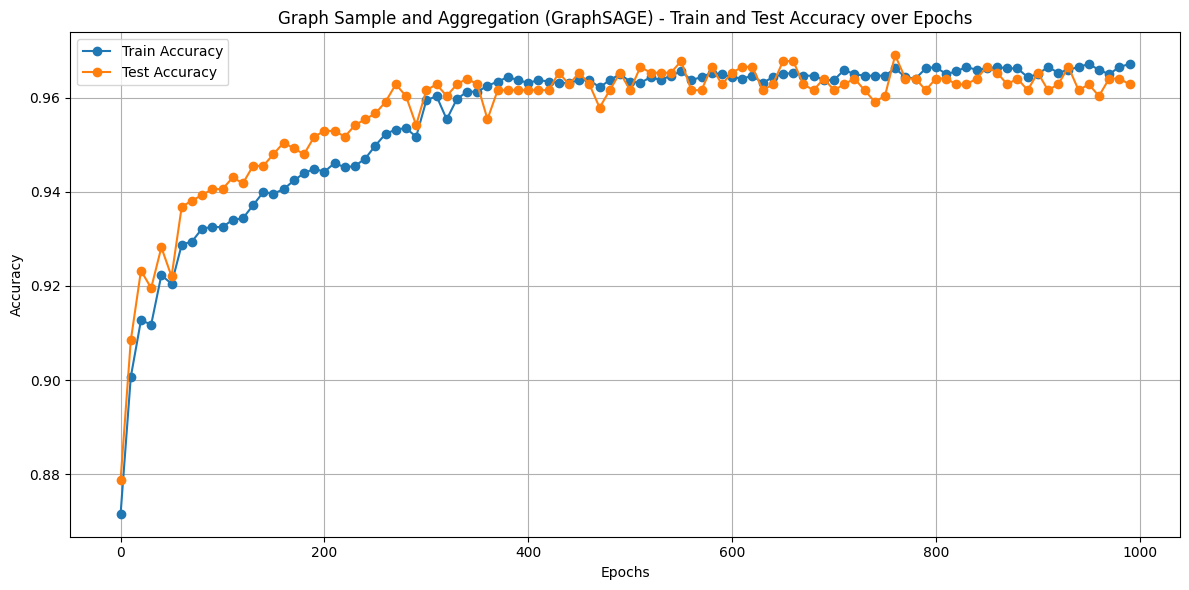

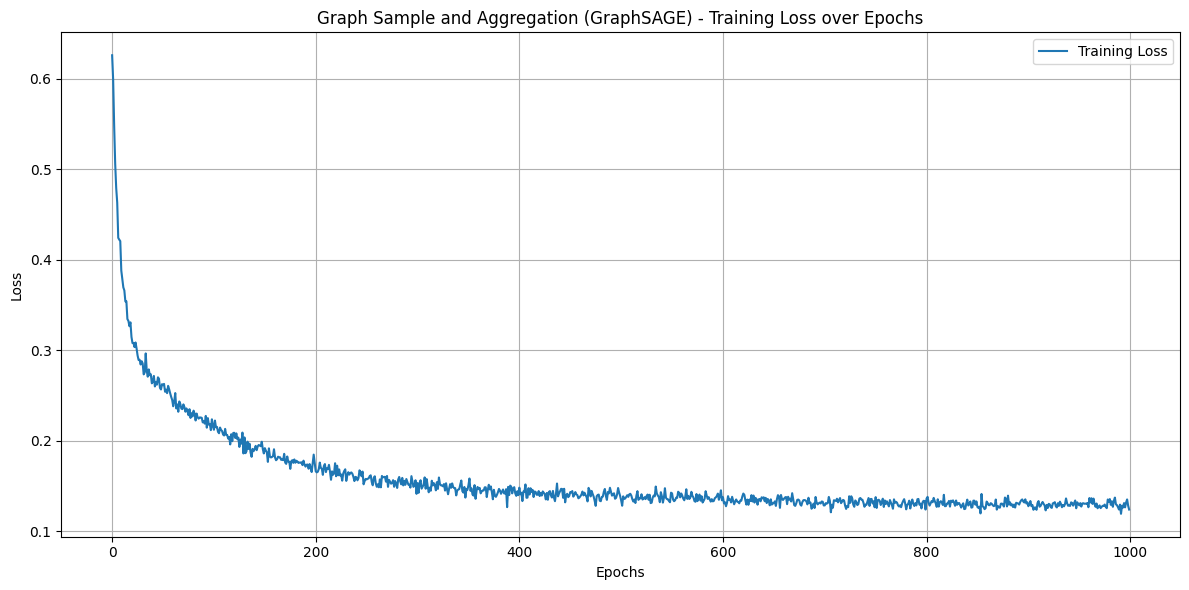

In [25]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_dim=16, num_layers=2, dropout_rate=0.5):
        super(GraphSAGE, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(num_node_features, hidden_dim))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))
        self.convs.append(SAGEConv(hidden_dim, num_classes))
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = self.dropout(x)

        x = self.convs[-1](x, edge_index)

        return F.log_softmax(x, dim=1)

# Split the data into training and testing sets
train_indices, test_indices = train_test_split(range(data.num_nodes), test_size=0.2, random_state=42)

# Create masks
train_mask = torch.tensor(train_indices, dtype=torch.long)
test_mask = torch.tensor(test_indices, dtype=torch.long)

# Define the model
num_classes = len(set(features_df['is_real']))
model = GraphSAGE(num_node_features=data.num_node_features, num_classes=num_classes)

# Define the loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Initialize lists to store loss and accuracy values
graph_sage_train_losses = []
graph_sage_train_accuracies = []
graph_sage_test_accuracies = []

# Training loop
def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients
    out = model(data)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()  # Derive gradients
    optimizer.step()  # Update parameters based on gradients
    return loss.item()

# Testing function
def test(mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out[mask].max(dim=1)[1]
        correct = pred.eq(data.y[mask]).sum().item()
        accuracy = correct / mask.size(0)
        return accuracy

# Training the model
graph_sage_num_epochs = 1000
start_time = time.time()  # Start the timer
for epoch in range(graph_sage_num_epochs):
    loss = train()
    graph_sage_train_losses.append(loss)

    if epoch % 10 == 0:
        train_acc = test(train_mask)
        test_acc = test(test_mask)

        graph_sage_train_accuracies.append(train_acc)
        graph_sage_test_accuracies.append(test_acc)


end_time = time.time()  # End the timer
graph_sage_training_time = end_time - start_time
graph_sage_final_loss = graph_sage_train_losses[len(graph_sage_train_losses)-1]
graph_sage_final_train_acc = graph_sage_train_accuracies[len(graph_sage_train_accuracies)-1]
graph_sage_final_test_acc = graph_sage_test_accuracies[len(graph_sage_test_accuracies)-1]
print(f'Final Epoch {graph_sage_num_epochs}, Loss: {graph_sage_final_loss:.4f}, Train Accurracy: {graph_sage_final_train_acc:.4f}, Test Accurracy: {graph_sage_final_test_acc:.4f}')

# Plotting the training and testing accuracy
graph_sage_epochs = list(range(0, graph_sage_num_epochs, 10))
plot_accuracy(graph_sage_epochs, graph_sage_train_accuracies, graph_sage_test_accuracies, 'Graph Sample and Aggregation (GraphSAGE) - Train and Test Accuracy over Epochs')

# Plotting the training loss over epochs
plot_loss(graph_sage_train_losses, 'Graph Sample and Aggregation (GraphSAGE) - Training Loss over Epochs')

### **Train & Test Results**

In [35]:
# Create a DataFrame to hold the results
final_results_df = pd.DataFrame({
    'Model': ['Graph Attention Network (GAT)', 'Graph Convolutional Networks (GCN)', 'Graph Sample and Aggregation (GraphSAGE)'],
    'Time (s)': [gat_training_time, gcn_training_time, graph_sage_training_time],
    'Final Epochs': [gat_num_epochs, gcn_num_epochs, graph_sage_num_epochs],
    'Final Loss': [gat_final_loss, gcn_final_loss, graph_sage_final_loss],
    'Train Accuracy': [gat_final_train_acc, gcn_final_train_acc, graph_sage_final_train_acc],
    'Test Accuracy': [gat_final_test_acc, gcn_final_test_acc, graph_sage_final_test_acc]
})

# Display the DataFrame
final_results_df

Model   Time (s)  Final Epochs  \
0             Graph Attention Network (GAT)  48.194153          1000   
1        Graph Convolutional Networks (GCN)  16.354273          1000   
2  Graph Sample and Aggregation (GraphSAGE)   8.669998          1000   

   Final Loss  Train Accuracy  Test Accuracy  
0    0.304262        0.904054       0.904703  
1    0.281990        0.904983       0.903465  
2    0.123789        0.967193       0.962871

The results in the table show the performance of three different Graph Neural Networks (GNNs) on the task of node classification:

<u>GAT:</u> While GAT took the longest to train (48 seconds), it achieved a reasonably high test accuracy of 0.9047. The longer training time is due to the attention mechanism, which is computationally more intensive but allows the model to weigh node neighbors more effectively.

<u>GCN:</u> GCN had a significantly shorter training time (16.35 seconds) compared to GAT, with a comparable test accuracy of 0.9034. This suggests that while GCN is faster, it achieves almost similar performance as GAT, albeit without the attention mechanism.

<u>GraphSAGE:</u> GraphSAGE was the fastest to train (8.66 seconds) and achieved the highest test accuracy of 0.9628, indicating its strong generalization capability. The lower final loss (0.1145) suggests that GraphSAGE effectively learned the underlying patterns in the data.

***Overall, GraphSAGE stands out as the best model, offering the highest test accuracy with the shortest training time, making it highly efficient and effective for this task.***

## **Conclusion**

Based on the comparative analysis of various machine learning and deep learning models, the best-performing model is **GraphSAGE**. It achieves the highest test accuracy of **96.29%**, demonstrating its superior ability to generalize to unseen data. Furthermore, GraphSAGE exhibits the lowest training time among deep learning models, making it an efficient choice for large-scale deployment.

In the realm of traditional machine learning models, **XGBoost** stands out with a test accuracy of **96.86%** and an excellent balance of precision, recall, and F1-score. However, it requires significantly more time to train compared to GraphSAGE.

Given its high accuracy, low training time, and effectiveness in handling graph-based data, **GraphSAGE** is the recommended model for detecting fake profiles in online social networks. It offers a robust solution that can scale well while maintaining top-tier performance.